## Reproduceable Research: Artifact No. 1

In this notebook I perform an exploratory analysis of the `Home Mortgage Disclosure Act` loan application data for 2024 as this was the most recent year that was publicly available. This analysis focuses on understanding approval rates and disparities in rate spreads between female and male applicants across geographical areas.

The National Association of Realtors recently published a report on [Who is Buying Now?](https://www.google.com/url?q=https%3A%2F%2Fwww.nar.realtor%2Fsites%2Fdefault%2Ffiles%2F2025-12%2F2025-12-09-nar-real-estate-forecast-summit-the-year-ahead-jessica-lautz-presentation-slides-who-is-buying-now-12-09-2025.pdf) Single woman made up 25% of first-time homebuyers in 2025 which is up from 11% in 1985. In addition, the growth in purchases by unmarried couples and Other (roomates) also increased. Married couples who in 1985 made up 75% of first-time homebuyers in 2025 only accounted for 50%. The rate of purchases for single-family homes by single-men remained relatively constant.

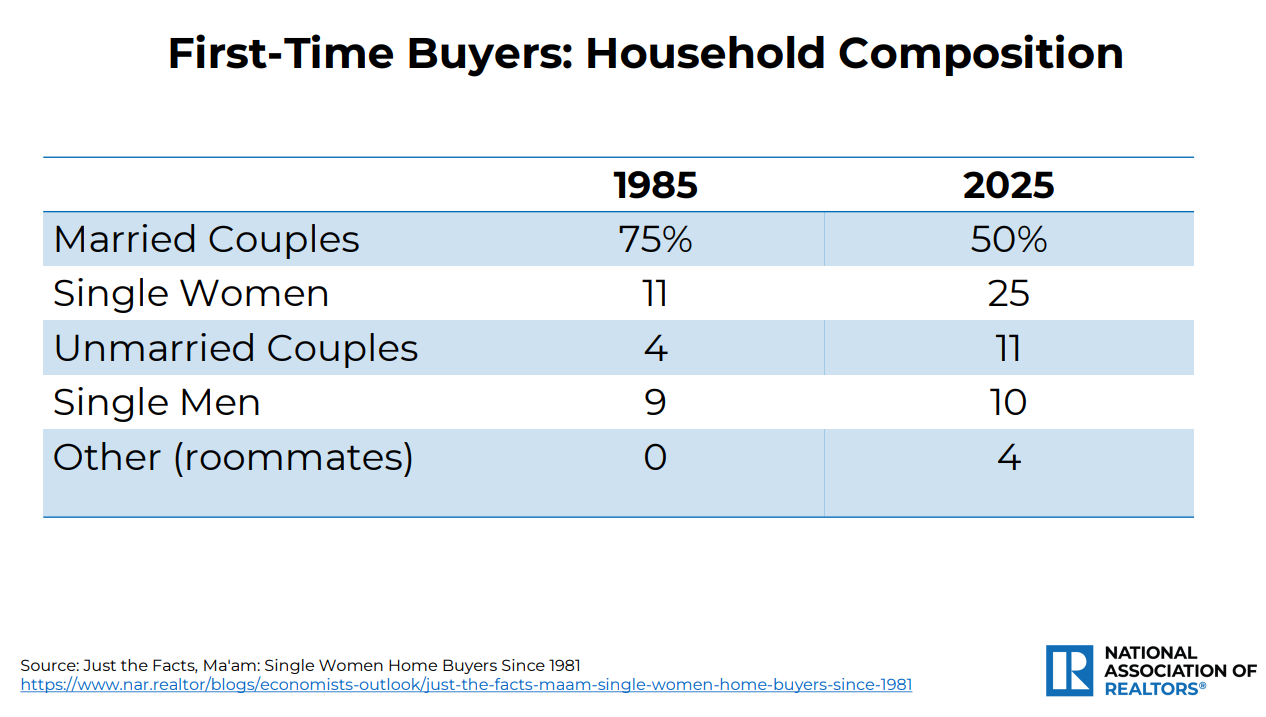

[Just the Facts, Ma'am: Single Women Home Buyers Since 1981](https://www.nar.realtor/blogs/economists-outlook/just-the-facts-maam-single-women-home-buyers-since-1981)

[2025 Real Estate Forecast: Who is Buying Now](https://www.nar.realtor/sites/default/files/2025-12/2025-12-09-nar-real-estate-forecast-summit-the-year-ahead-jessica-lautz-presentation-slides-who-is-buying-now-12-09-2025.pdf)


**Key Steps Covered:**

- **Data Setup and Loading:** Initial configuration, loading of HMDA data, and preparation of geographical shapefiles.
- **Data Cleaning and Filtering:** Normalizing data codes, applying cohort filters, and flagging key variables like approval status and applicant gender.
- **Statistical Analysis:** Calculating approval rates by state and MSA, performing t-tests to compare rate spreads between genders, and running OLS regression models with fixed effects.
- **Geospatial Visualization:** Creating choropleth maps to visualize approval rates across states and CBSAs.
- **Results Presentation:** Displaying key tables and figures to summarize findings.

**Find the raw data from the source:**

TIGER/Line Shapefiles Format: The core TIGER/Line Files and Shapefiles do not include demographic data, but they do contain geographic entity codes that can be linked to the Census Bureau’s demographic data, available on data.census.gov. https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

HMDA Dataset: These files contain all data fields available in the public data record and can be used for advanced analysis. There is also an API. For questions/suggestions, contact hmdahelp@cfpb.gov. https://ffiec.cfpb.gov/data-browser/data/2024?category=states



The accompanying notebooks in this series are:
- [Artifcat No. 1: HMDA Gender and Geography](https://colab.research.google.com/drive/1bIIbRIASm6mOUk4jteGboGExWRyL6tDe?usp=sharing)
- [Artifcat No. 2: HMDA Loan Characteristics by Race & Gender](https://colab.research.google.com/drive/1w6yQhZUyiMK5FvECOKzvpNa8FClOQ0KU?usp=sharing)
- [Artifact No. 3: Tapping APIs for Multi-Year Analysis](https://colab.research.google.com/drive/1f2zZ_LIhGzuQVhrdgqVDT8nR3ff6DXze?usp=sharing)

Github Repos:
- [HMDA Lending Equity](https://github.com/hxe00570/HMDA_lending_equity)
- [HMDA Loan Characteristics](https://colab.research.google.com/drive/1bIIbRIASm6mOUk4jteGboGExWRyL6tDe?usp=sharing)


# 2024 HMDA Loan Application Analysis

This analysis of `2024 Home Mortgage Disclosure Act (HMDA)` data shows mortgage approval rates, loan pricing, and geographical patterns for single-party applicants. The global approval rate for single-family, owner-occupied mortgage applicants in the states and territories sampled is just shy of 60%. However, approval rates vary significantly across geographies, with Wisconsin and North Dakota showing the highest rates, while Louisiana and Mississippi have some of the lowest.

A notable finding is a consistent **gender disparity in loan rate spreads**. On average, female applicants receive slightly lower interest rate spreads than male applicants, even after controlling for various loan characteristics and geographical factors (states and metropolitan areas). This "female effect" ranges from **-1.61 to -5.39 basis points lower** depending on the loan program (Conventional, FHA, VA, USDA).

Geographically, this disparity is not uniform. While some states like Mississippi and Connecticut show females receiving significantly lower rates, others such as New York and Illinois demonstrate the opposite, with females paying higher rate spreads. Heatmaps further highlight these complex regional and program-specific variations, indicating distinct patterns in loan accessibility and pricing across the nation.

While these findings are interesting, they are limited to a single year and notably this dataset does not include any information on applicant credit score or income. Finally, I only considered `approved` loans for `residential` occupancy and held fixed `debt_to_income_ratio`, `loan_to_value_ratio`, `reason_for_denial` or `loan_amount` among other variables.

In a related analysis (Artifact No.2) I examine `loan_amount`, `loan_to_value_ratio`, `rate_spread`, and `debt_to_income_ratio` by `derived_sex` and `derived_race`. It appears that single-men apply for a higher average `loan_amount` than single-female applicants, an observation that held true across racial groups. More research would be needed to examine the significance of this relationship. Artifact No. 3 begins the next step of aggregating multi-year data and identifying additional data sources to further this analysis.


### 0) Setup: Mount Drives | Create Output Folders | Build Helper Functions

This section initializes the necessary output directories for figures, tables, and checkpoints. It also defines utility functions for safely saving `pandas` DataFrames to CSV files and `Matplotlib` and `Seaborn`
figures to image files, ensuring that parent directories are created if they don't exist.

Due to the size of this data, it is necessary to use a High-Ram Python 3 instance. This will not be the default and should be specified before running any code.

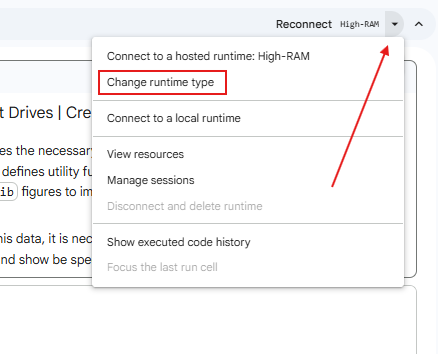

Select the down chevron in the top right hand of the notebook next to the Connect or Reconnect button.

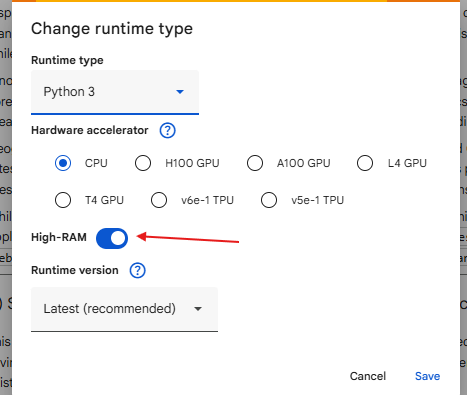

Select Change Runtime and ensure that you have selected a Python3 runtime and turned on High-Ram and CPU instance. If you do not take this step before Step 0 then you will hit a session time out and have to do it anyway but not without first restarting the entire notebook. So just do it now and save yourself time.

In [ ]:


# If you have not designated the Python3 CPU High-Ram runtime then your process timed out around step 4 or 5.
# This happened to me so I wrote this function to clean and unmount then restart the notebook since I kept getting errors.
# You don't have to run it really if you are initiating for the first time
# I left it here for those who will just click run all and need to investigate why the process failed later
from google.colab import drive
try:
    drive.flush_and_unmount()
except Exception as e:
    print("Flush/unmount raised:", e)

# After this cell, click: Runtime → Restart runtime


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # wait for auth flow


Mounted at /content/drive


In [ ]:

import os
print(os.listdir('/content/drive/MyDrive/')[:10])  # should list your Drive items I placed this file in a specific folder so
                                                                                 # I am pointing to it you will need to update with a file path that is true for your drive folder if you choose this method


['state-and-local-association-website-market-data-pages-urls-08-19-2022 (1).xls', '2024_combined_mlar.zip', 'tl_2024_us_state.zip', 'tl_2025_us_cbsa.zip', 'tl_2025_us_csa.zip', 'tl_2025_us_metdiv.zip', 'tl_2024_us_state', 'tl_2025_us_cbsa', 'applicantsDB', 'year_2024.csv']


In [ ]:

# 0) Setup: output folders & small helpers here in Colab >> These are all temporary and if you exit the tab or the session times out, you will need to rebuild
import os
from pathlib import Path

OUT_FIG_DIR = 'output/figures'
OUT_TAB_DIR = 'output/tables'
OUT_CKP_DIR = 'output/checkpoints'

for d in (OUT_FIG_DIR, OUT_TAB_DIR, OUT_CKP_DIR):
    Path(d).mkdir(parents=True, exist_ok=True)

def safe_save_csv(df, path, **kwargs):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(p, **kwargs)
    print(f"Saved: {p}")

def safe_save_fig(path, dpi=300):
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    import matplotlib.pyplot as plt
    plt.savefig(p, dpi=dpi)
    print(f"Saved: {p}")


### 1) Define Data Paths

Set-up main path to the HMDA data and the geographical shapefiles (for states and CBSAs).

A quick check to make sure these files are actually there before we start, so we know all our data is ready to go.

In [ ]:
# 1) EDIT these paths to point to the location you saved the files on your drive:
CSV_PATH   = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/year_2024.csv'
STATE_ZIP  = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2024_us_state.zip'
CBSA_ZIP   = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2025_us_cbsa.zip'

import os
assert os.path.exists(CSV_PATH), f"CSV not found: {CSV_PATH}"
assert os.path.exists(STATE_ZIP), f"State ZIP not found: {STATE_ZIP}"
assert os.path.exists(CBSA_ZIP), f"CBSA ZIP not found: {CBSA_ZIP}"

print("Paths OK.")


Paths OK.


In [ ]:
import os

# Search for HMDA file in MyDrive via keyword alternatives
hmda_file_path = None
for root, dirs, files in os.walk('/content/drive/MyDrive/CIS-2330_Database_Fundamentals/'): #Update to your correct file path
    for file in files:
        if 'year_2024' in file.lower() and file.endswith('.csv'):
            hmda_file_path = os.path.join(root, file)
            print("Found HMDA file:", hmda_file_path)

if hmda_file_path is None:
    raise FileNotFoundError("HMDA file not found. Please check your Drive.")


Found HMDA file: /content/drive/MyDrive/CIS-2330_Database_Fundamentals/year_2024.csv


### 2) Install `mapclassify` for Choropleth Legends

Intalling the mapclassify library because it helps create clean legends with quantile and fixed break features.

In [ ]:

# 2) (Optional) install mapclassify for quantile/fixed-break legends
%pip install --quiet mapclassify


### 3) Load HMDA Data

Pull HMDA data from CSV file on Google Drive using pandas `read_csv` and generate dataframe of columns for analysis. The `USEGEOCOLS` to restrict is called in the read_csv statment to keep things focused.  In addition, will load as `dtypes=str` and `low_memory=False` because this dataset is pretty big.

Then a peek at what has loaded, by showing the first and last few rows of the DataFrame

In [ ]:

# 3) Load HMDA columns
import pandas as pd

USEGEOCOLS = [
    'state_code','derived_msa-md',
    'loan_purpose','occupancy_type','derived_dwelling_category',
    'action_taken','derived_sex',
    'loan_type',
    'rate_spread','loan_amount','income',
    'loan_to_value_ratio','debt_to_income_ratio','interest_rate'
]

df_geo = pd.read_csv(CSV_PATH, usecols=USEGEOCOLS, dtype=str, low_memory=False)
print("Loaded:", df_geo.shape)
print(df_geo.head())
print(df_geo.tail())


Loaded: (12229298, 14)
  derived_msa-md state_code             derived_dwelling_category  \
0          38060         AZ  Single Family (1-4 Units):Site-Built   
1          24780         NC  Single Family (1-4 Units):Site-Built   
2          29414         IN  Single Family (1-4 Units):Site-Built   
3          17900         SC  Single Family (1-4 Units):Site-Built   
4          36420         OK  Single Family (1-4 Units):Site-Built   

         derived_sex action_taken loan_type loan_purpose loan_amount  \
0  Sex Not Available            5         3           32    395000.0   
1             Female            1         3            1    305000.0   
2               Male            1         3            1    455000.0   
3              Joint            4         1            1    135000.0   
4              Joint            4         3            1    375000.0   

  loan_to_value_ratio interest_rate rate_spread occupancy_type income  \
0                 NaN           NaN         NaN         

### 4) Normalize Codes, Rename MSA, Filters & Flags

This next bit cleans up and ensures the data is ready for analysis, so I do a few key things here:
- First, rename that `derived_msa-md` column to `derived_msa_md` it just makes it easier to work with in our code and I hit errors working with this variable in `matplotlib`.
- Some of our categories, like `loan_purpose` and `loan_type`, will be transformed into numbers so they play nicely with the tests we want to run next.
- Then, some filtering since the cohort I run the tests on should have the data we need available for the records included in our study population. In this case, I am interested in residential purchases of single-family homes 1-4 units by single purchasers.
- Add a simple 'yes/no' flags: one for 'approved' loans, and others to easily spot `female_app` and `male_app` in our statistical models.
- A quick conversion for pricing and loan term details turning them into numbers.
- Finally, save all this neatly filtered data as a Parquet file.



In [ ]:

# 4) Normalize codes, rename MSA, filters & flags
import numpy as np

to_num = lambda s: pd.to_numeric(s, errors='coerce')

# Safe rename for formulas
if 'derived_msa-md' in df_geo.columns:
    df_geo = df_geo.rename(columns={'derived_msa-md': 'derived_msa_md'})

# Normalize HMDA coded fields
for c in ['loan_purpose','occupancy_type','action_taken','loan_type']:
    df_geo[c] = to_num(df_geo[c])

# Uniform cohort filters
filt = (
    (df_geo['loan_purpose'] == 1) &
    (df_geo['occupancy_type'] == 1) &
    (df_geo['derived_dwelling_category'] == 'Single Family (1-4 Units):Site-Built')
)
df_f = df_geo.loc[filt].copy()

# Flags
df_f['approved']   = (df_f['action_taken'] == 1).astype(int)
df_f['female_app'] = (df_f['derived_sex'] == 'Female')
df_f['male_app']   = (df_f['derived_sex'] == 'Male')

# Pricing/terms
for c in ['rate_spread','loan_amount','income','loan_to_value_ratio','debt_to_income_ratio','interest_rate']:
    df_f[c] = to_num(df_f[c])

print("Cohort rows:", len(df_f))
# Save checkpoint
df_f.to_parquet(f'{OUT_CKP_DIR}/filtered_hmda_2024.parquet', index=False)
print("Saved:", f'{OUT_CKP_DIR}/filtered_hmda_2024.parquet')


Cohort rows: 5294989
Saved: output/checkpoints/filtered_hmda_2024.parquet


### 5) Approval Rates & Top/Bottom 10 State with Wilson 95% Confidence Intervals

Figure out the loan approval rates for each state using the Wilson score interval method to get esimate 95% confidence intervals. Helpful when looking at proportions, like approval rates. To make sure the results are reliable, I'm cutting out U.S. territories and any states that don't have a minimum number of applications. Save to CSV then show the Top 10 and Bottom 10 States based on approval rates

In [ ]:

# 5) Approval rates by state + Wilson 95% CI
from statsmodels.stats.proportion import proportion_confint

by_state = (
    df_f.groupby('state_code')
        .agg(apps=('approved','size'), approvals=('approved','sum'))
        .assign(approval_rate=lambda d: d['approvals']/d['apps'])
        .reset_index()
)

ci_low, ci_high = proportion_confint(
    by_state['approvals'].astype(int),
    by_state['apps'].astype(int),
    alpha=0.05, method='wilson'
)
by_state['ci_low']  = ci_low
by_state['ci_high'] = ci_high

# Exclude territories (optional) and apply minimum apps
territories = {'PR','GU','VI','AS','MP'}
MIN_APPS = 10_000

robust_rank = (
    by_state[~by_state['state_code'].isin(territories) & (by_state['apps'] >= MIN_APPS)]
    .sort_values('approval_rate', ascending=False)
    .reset_index(drop=True)
)

# Save tables
safe_save_csv(by_state,   f'{OUT_TAB_DIR}/approval_rate_by_state_2024.csv', index=False)
safe_save_csv(robust_rank,f'{OUT_TAB_DIR}/approval_rate_by_state_2024_ci_minapps.csv', index=False)

# Show top/bottom 10 robust ranks
print("Top 10 states (>=10k apps, territories excluded):")
display(robust_rank.head(10))
print("Bottom 10 states (>=10k apps, territories excluded):")
display(robust_rank.tail(10))


Saved: output/tables/approval_rate_by_state_2024.csv
Saved: output/tables/approval_rate_by_state_2024_ci_minapps.csv
Top 10 states (>=10k apps, territories excluded):


state_code    apps  approvals  approval_rate    ci_low   ci_high
0         WI   77569      53809       0.693692  0.690439  0.696926
1         ND   10836       7213       0.665652  0.656712  0.674474
2         IA   51131      33659       0.658289  0.654167  0.662388
3         MN   93093      60955       0.654775  0.651715  0.657823
4         SD   12488       8099       0.648543  0.640125  0.656869
5         NH   18349      11808       0.643523  0.636563  0.650422
6         MI  136838      87409       0.638777  0.636228  0.641318
7         AK   10318       6552       0.635007  0.625669  0.644244
8         CT   50030      31419       0.628003  0.623758  0.632229
9         ID   35500      22278       0.627549  0.622507  0.632564

Bottom 10 states (>=10k apps, territories excluded):


state_code    apps  approvals  approval_rate    ci_low   ci_high
38         NV   59781      33400       0.558706  0.554722  0.562682
39         MD  104374      58067       0.556336  0.553320  0.559348
40         GA  200043     109379       0.546777  0.544595  0.548958
41         DE   19996      10832       0.541708  0.534795  0.548606
42         OK   65631      35488       0.540720  0.536905  0.544530
43         LA   58499      31324       0.535462  0.531418  0.539501
44         NJ  125883      67189       0.533742  0.530985  0.536496
45         TX  576747     303996       0.527087  0.525799  0.528376
46         FL  462751     242180       0.523348  0.521909  0.524787
47         AR   52671      27280       0.517932  0.513664  0.522198

In [ ]:
print(robust_rank.approval_rate.mean())
print(robust_rank.approval_rate.std())
print(robust_rank.approval_rate.median())
print(robust_rank.approval_rate.min())
print(robust_rank.approval_rate.max())


0.5949265272771318
0.04027233040333555
0.597961305254707
0.5179320688804085
0.6936920677074605


### 6) Female vs. Male Rate Spread Analysis (Winsorized)

Narrow down to just the approved loans with good rate spread data. Then, ensure extreme values don't throw off our results, will `winsorize` the rate spread data – capping the highest and lowest 1% of values. After that, run a two-sample t-test (a Welch's t-test, to be precise) to see if there's a statistically significant difference in the average rate spreads for female versus male applicants. Generate and save some basic descriptive stats for export and print

In [ ]:

# 6) Female vs Male (winsorized) on approved loans
import scipy.stats as stats

cond = df_f[(df_f['approved']==1) & (df_f['rate_spread'].notna()) & (df_f['derived_sex'].isin(['Female','Male']))].copy()

q1, q99 = cond['rate_spread'].quantile([0.01, 0.99])
cond_ws = cond.assign(rate_spread=cond['rate_spread'].clip(lower=q1, upper=q99))

female_rs = cond_ws.loc[cond_ws['derived_sex']=='Female','rate_spread'].dropna()
male_rs   = cond_ws.loc[cond_ws['derived_sex']=='Male','rate_spread'].dropna()

diff  = float(female_rs.mean() - male_rs.mean())
tstat, pval = stats.ttest_ind(female_rs, male_rs, equal_var=False)

print(f"Unadjusted mean diff (Female - Male), winsorized: {diff:.4f}  (~{diff*100:.2f} bps)")
print(f"t-stat = {tstat:.2f}, p = {pval:.4g}")

desc = cond_ws.groupby('derived_sex')['rate_spread'].describe()
display(desc)

# Save tables
safe_save_csv(desc,      f'{OUT_TAB_DIR}/rate_spread_descriptive_by_sex_approved_2024.csv')
safe_save_csv(cond_ws[['derived_sex','rate_spread']], f'{OUT_TAB_DIR}/rate_spread_winsorized_pairs_2024.csv', index=False)


Unadjusted mean diff (Female - Male), winsorized: -0.0142  (~-1.42 bps)
t-stat = -7.15, p = 8.394e-13


count      mean       std   min    25%    50%    75%    max
derived_sex                                                                
Female       620783.0  0.070303  1.259794 -6.55 -0.215  0.198  0.634  2.708
Male         949143.0  0.084495  1.143675 -6.55 -0.257  0.165  0.607  2.708

Saved: output/tables/rate_spread_descriptive_by_sex_approved_2024.csv
Saved: output/tables/rate_spread_winsorized_pairs_2024.csv


### 7) Adjusted OLS Fixed Effects Models with Cluster-Robust Standard Errors
Use adjusted OLS regression, to further example `female effect` on rate spreads. Control for loan details and account for differences across states and metro areas.

Build two main models:
1.  **State-level Model:** This one looks at the big picture, accounting for unique characteristics of each state.
2.  **Metro-level Model:** This dives a bit deeper, considering the specific dynamics of different metropolitan areas (MSAs).



In [ ]:

# 7) Adjusted OLS FE + cluster-robust SEs (replacement)
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# --- Build regression sample (approved + rate_spread present; already winsorized in cond_ws) ---
reg = cond_ws.dropna(subset=['rate_spread','loan_amount','income','loan_to_value_ratio','debt_to_income_ratio']).copy()
reg['loan_amount_k'] = reg['loan_amount'] / 1000.0  # scaling for stability

# --- Helpers: build aligned model frames for State FE and MSA FE ---
def make_state_df(reg_df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop rows with NA for all variables appearing in the State-FE formula.
    Create cluster labels aligned to model rows.
    """
    needed = [
        'rate_spread','female_app','loan_amount_k','income',
        'loan_to_value_ratio','debt_to_income_ratio','state_code','loan_type'
    ]
    mdf = reg_df.dropna(subset=needed).copy()
    # Clean cluster labels (numeric codes for statsmodels)
    mdf['cluster_state'] = pd.Categorical(mdf['state_code'].astype(str).fillna('UNKNOWN')).codes
    return mdf

def make_msa_df(reg_df: pd.DataFrame) -> pd.DataFrame:
    """
    Drop rows with NA for all variables appearing in the MSA-FE formula.
    Create cluster labels aligned to model rows.
    """
    needed = [
        'rate_spread','female_app','loan_amount_k','income',
        'loan_to_value_ratio','debt_to_income_ratio','derived_msa_md','loan_type'
    ]
    mdf = reg_df.dropna(subset=needed).copy()
    mdf['cluster_msa'] = pd.Categorical(mdf['derived_msa_md'].astype(str).fillna('UNKNOWN')).codes
    return mdf

state_df = make_state_df(reg)
msa_df   = make_msa_df(reg)

print("STATE model rows:", len(state_df), "| clusters:", len(np.unique(state_df['cluster_state'])))
print("MSA   model rows:", len(msa_df),   "| clusters:", len(np.unique(msa_df['cluster_msa'])))

# --- Fit models (State FE and MSA FE), clustering on geography ---
model_state = smf.ols(
    'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(state_code) + C(loan_type)',
    data=state_df
).fit(cov_type='cluster', cov_kwds={'groups': state_df['cluster_state']})

model_msa = smf.ols(
    'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(derived_msa_md) + C(loan_type)',
    data=msa_df
).fit(cov_type='cluster', cov_kwds={'groups': msa_df['cluster_msa']})

print("=== STATE FE (clustered by state) ===")
print(model_state.summary())
print("\n=== MSA FE (clustered by MSA) ===")
print(model_msa.summary())

# --- Robust extractor: handles 'female_app' or 'female_app[T.True]' ---
def summarize_female_effect_any(results, label, base='female_app'):
    """
    Return coef & 95% CI in basis points for either 'female_app' or 'female_app[T.True]'.
    """
    candidates = [base, f'{base}[T.True]']
    present = [name for name in candidates if name in results.params.index]
    if not present:
        return {'model': label, 'coef_bps': np.nan, 'ci_low_bps': np.nan, 'ci_high_bps': np.nan}
    name = present[0]

    coef = results.params[name]
    ci   = results.conf_int().loc[name] if name in results.conf_int().index else [np.nan, np.nan]

    return {
        'model': label,
        'coef_bps': float(coef) * 100.0,
        'ci_low_bps': float(ci[0]) * 100.0,
        'ci_high_bps': float(ci[1]) * 100.0
    }

# --- Build and save OVERALL FE summary (in bps) ---
summ_df_fixed = pd.DataFrame([
    summarize_female_effect_any(model_state, 'State FE + loan_type'),
    summarize_female_effect_any(model_msa,   'MSA FE + loan_type')
])
display(summ_df_fixed)

summ_df_fixed.to_csv(f'{OUT_TAB_DIR}/female_effect_bps_overall_FE_2024.csv', index=False)
print("Saved:", f'{OUT_TAB_DIR}/female_effect_bps_overall_FE_2024.csv')


STATE model rows: 913833 | clusters: 54
MSA   model rows: 914010 | clusters: 418
=== STATE FE (clustered by state) ===
                            OLS Regression Results                            
Dep. Variable:            rate_spread   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     673.9
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           1.84e-50
Time:                        23:37:28   Log-Likelihood:            -1.4640e+06
No. Observations:              913833   AIC:                         2.928e+06
Df Residuals:                  913771   BIC:                         2.929e+06
Df Model:                          61                                         
Covariance Type:              cluster                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
--

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 61, but rank is 8
  warnings.warn('covariance of constraints does not have full '


                            OLS Regression Results                            
Dep. Variable:            rate_spread   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     5963.
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:37:29   Log-Likelihood:            -1.4589e+06
No. Observations:              914010   AIC:                         2.919e+06
Df Residuals:                  913584   BIC:                         2.924e+06
Df Model:                         425                                         
Covariance Type:              cluster                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 425, but rank is 8
  warnings.warn('covariance of constraints does not have full '


model  coef_bps  ci_low_bps  ci_high_bps
0  State FE + loan_type -3.514649   -5.000076    -2.029222
1    MSA FE + loan_type -3.183459   -4.068019    -2.298898

Saved: output/tables/female_effect_bps_overall_FE_2024.csv


In [ ]:

# 7a. Program-stratified FE summaries (rebuild & save)
program_rows = []
programs = {1:'Conventional', 2:'FHA', 3:'VA', 4:'USDA'}

for code, label in programs.items():
    reg_lt_state = state_df[state_df['loan_type'] == code]
    reg_lt_msa   = msa_df[msa_df['loan_type']   == code]

    # State FE within program
    if len(reg_lt_state) >= 5000:
        mod_state_lt = smf.ols(
            'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(state_code)',
            data=reg_lt_state
        ).fit(cov_type='cluster', cov_kwds={'groups': reg_lt_state['cluster_state']})
        program_rows.append(summarize_female_effect_any(mod_state_lt, f'{label} — State FE'))

    # MSA FE within program
    if len(reg_lt_msa) >= 5000:
        mod_msa_lt = smf.ols(
            'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(derived_msa_md)',
            data=reg_lt_msa
        ).fit(cov_type='cluster', cov_kwds={'groups': reg_lt_msa['cluster_msa']})
        program_rows.append(summarize_female_effect_any(mod_msa_lt, f'{label} — MSA FE'))

prog_summ_fixed = pd.DataFrame(program_rows)
display(prog_summ_fixed)

prog_summ_fixed.to_csv(f'{OUT_TAB_DIR}/female_effect_bps_program_FE_2024.csv', index=False)
print("Saved:", f'{OUT_TAB_DIR}/female_effect_bps_program_FE_2024.csv')


model  coef_bps  ci_low_bps  ci_high_bps
0  Conventional — State FE -3.554614   -5.121808    -1.987420
1    Conventional — MSA FE -3.506277   -4.594532    -2.418023
2           FHA — State FE -2.009353   -3.267697    -0.751009
3             FHA — MSA FE -1.612448   -2.503464    -0.721432
4            VA — State FE -5.388107   -7.389782    -3.386431
5              VA — MSA FE -4.063446   -5.619085    -2.507807
6          USDA — State FE -5.328282  -10.735010     0.078446
7            USDA — MSA FE -3.838256   -8.659376     0.982865

Saved: output/tables/female_effect_bps_program_FE_2024.csv


In [ ]:

import pandas as pd

print(pd.read_csv(f'{OUT_TAB_DIR}/female_effect_bps_overall_FE_2024.csv'))
print(pd.read_csv(f'{OUT_TAB_DIR}/female_effect_bps_program_FE_2024.csv').head())


                  model  coef_bps  ci_low_bps  ci_high_bps
0  State FE + loan_type -3.514649   -5.000076    -2.029222
1    MSA FE + loan_type -3.183459   -4.068019    -2.298898
                     model  coef_bps  ci_low_bps  ci_high_bps
0  Conventional — State FE -3.554614   -5.121808    -1.987420
1    Conventional — MSA FE -3.506277   -4.594532    -2.418023
2           FHA — State FE -2.009353   -3.267697    -0.751009
3             FHA — MSA FE -1.612448   -2.503464    -0.721432
4            VA — State FE -5.388107   -7.389782    -3.386431


### 8) Program-Stratified Fixed Effects Models

**Diving Deeper: How Loan Programs Influence the `Female Effect`**
See if women face different rate spreads in, say, a Conventional loan compared to an FHA loan, even after controlling for various other factors.

In [ ]:

# 8) Program-stratified FE models (replacement)
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd

# Robust extractor: handles 'female_app' or 'female_app[T.True]'
def summarize_female_effect_any(results, label, base='female_app'):
    candidates = [base, f'{base}[T.True]']
    present = [name for name in candidates if name in results.params.index]
    if not present:
        return {'model': label, 'coef_bps': np.nan, 'ci_low_bps': np.nan, 'ci_high_bps': np.nan}
    name = present[0]
    coef = results.params[name]
    ci = results.conf_int().loc[name] if name in results.conf_int().index else [np.nan, np.nan]
    return {
        'model': label,
        'coef_bps': float(coef) * 100.0,
        'ci_low_bps': float(ci[0]) * 100.0,
        'ci_high_bps': float(ci[1]) * 100.0
    }

# Helper: build program-specific model frame with aligned cluster labels
def make_program_state_df(state_df_full: pd.DataFrame, lt_code: int) -> pd.DataFrame:
    needed = ['rate_spread','female_app','loan_amount_k','income',
              'loan_to_value_ratio','debt_to_income_ratio','state_code']
    mdf = state_df_full[state_df_full['loan_type'] == lt_code].dropna(subset=needed).copy()
    # Rebuild cluster codes on the filtered frame
    mdf['cluster_state'] = pd.Categorical(mdf['state_code'].astype(str).fillna('UNKNOWN')).codes
    return mdf

def make_program_msa_df(msa_df_full: pd.DataFrame, lt_code: int) -> pd.DataFrame:
    needed = ['rate_spread','female_app','loan_amount_k','income',
              'loan_to_value_ratio','debt_to_income_ratio','derived_msa_md']
    mdf = msa_df_full[msa_df_full['loan_type'] == lt_code].dropna(subset=needed).copy()
    mdf['cluster_msa'] = pd.Categorical(mdf['derived_msa_md'].astype(str).fillna('UNKNOWN')).codes
    return mdf

programs = {1:'Conventional', 2:'FHA', 3:'VA', 4:'USDA'}
rows = []

for code, label in programs.items():
    # Build aligned frames per program
    reg_lt_state = make_program_state_df(state_df, code)
    reg_lt_msa   = make_program_msa_df(msa_df,   code)

    # Fit State FE within program (skip small samples)
    if len(reg_lt_state) >= 5000:
        try:
            mod_state_lt = smf.ols(
                'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(state_code)',
                data=reg_lt_state
            ).fit(cov_type='cluster', cov_kwds={'groups': reg_lt_state['cluster_state']})
            rows.append(summarize_female_effect_any(mod_state_lt, f'{label} — State FE'))
        except Exception as e:
            print(f"Warning: {label} — State FE failed: {e}")
    else:
        print(f"Skipping {label} — State FE (sample < 5,000): n={len(reg_lt_state)}")

    # Fit MSA FE within program (skip small samples)
    if len(reg_lt_msa) >= 5000:
        try:
            mod_msa_lt = smf.ols(
                'rate_spread ~ female_app + loan_amount_k + income + loan_to_value_ratio + debt_to_income_ratio + C(derived_msa_md)',
                data=reg_lt_msa
            ).fit(cov_type='cluster', cov_kwds={'groups': reg_lt_msa['cluster_msa']})
            rows.append(summarize_female_effect_any(mod_msa_lt, f'{label} — MSA FE'))
        except Exception as e:
            print(f"Warning: {label} — MSA FE failed: {e}")
    else:
        print(f"Skipping {label} — MSA FE (sample < 5,000): n={len(reg_lt_msa)}")

# Build summary DataFrame & save
prog_summ = pd.DataFrame(rows)
display(prog_summ)
safe_save_csv(prog_summ, f'{OUT_TAB_DIR}/female_effect_bps_program_FE_2024.csv', index=False)
print("Saved:", f'{OUT_TAB_DIR}/female_effect_bps_program_FE_2024.csv')


model  coef_bps  ci_low_bps  ci_high_bps
0  Conventional — State FE -3.554614   -5.121808    -1.987420
1    Conventional — MSA FE -3.506277   -4.594532    -2.418023
2           FHA — State FE -2.009353   -3.267697    -0.751009
3             FHA — MSA FE -1.612448   -2.503464    -0.721432
4            VA — State FE -5.388107   -7.389782    -3.386431
5              VA — MSA FE -4.063446   -5.619085    -2.507807
6          USDA — State FE -5.328282  -10.735010     0.078446
7            USDA — MSA FE -3.838256   -8.659376     0.982865

Saved: output/tables/female_effect_bps_program_FE_2024.csv
Saved: output/tables/female_effect_bps_program_FE_2024.csv


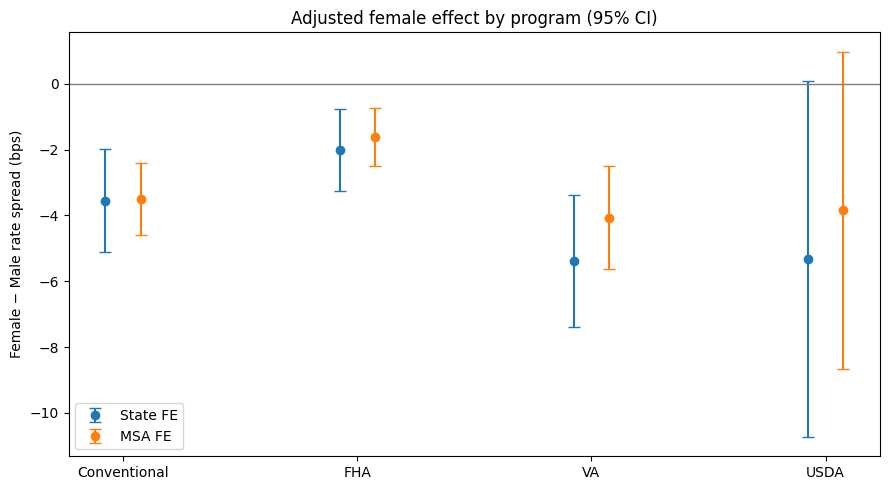

Saved: output/figures/female_effect_by_program_bars_2024.png


In [ ]:

# Visualize program effects with 95% CI bars
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = prog_summ.copy()
df['program'] = df['model'].str.split(' — ').str[0]
df['fe_type'] = df['model'].str.split(' — ').str[1]

# Order programs
order = ['Conventional', 'FHA', 'VA', 'USDA']
df['program'] = pd.Categorical(df['program'], categories=order, ordered=True)

# Plot
plt.figure(figsize=(9,5))
for i, fe in enumerate(['State FE', 'MSA FE']):
    sub = df[df['fe_type'] == fe].sort_values('program')
    x = np.arange(len(sub))
    y = sub['coef_bps'].values
    yerr = np.vstack([y - sub['ci_low_bps'].values, sub['ci_high_bps'].values - y])
    plt.errorbar(x + (i-0.5)*0.15, y, yerr=yerr, fmt='o', capsize=4,
                 label=fe, color=('#1f77b4' if fe=='State FE' else '#ff7f0e'))

plt.axhline(0, color='gray', linewidth=1)
plt.xticks(np.arange(len(order)), order)
plt.ylabel('Female − Male rate spread (bps)')
plt.title('Adjusted female effect by program (95% CI)')
plt.legend()
plt.tight_layout()
plt.savefig(f'{OUT_FIG_DIR}/female_effect_by_program_bars_2024.png', dpi=300)
plt.show()

print("Saved:", f'{OUT_FIG_DIR}/female_effect_by_program_bars_2024.png')


### 9) State-Level Female vs. Male Rate Spread Differences with FDR Correction

I was curious if loan pricing varies significantly for women and men, even after accounting for various factors. For each state where there is enough data from both female and male applicants, perform a **Welch's t-test**. Try to pinpoint if there are truly significant differences in the *average rate spread* between these two groups.

Running many tests (one for each state!), there's a risk of finding "significant" results purely by chance. To address this, apply a **False Discovery Rate (FDR) correction** to p-values. This ensures our findings are more robust and less likely to be false positives.

Finally, present these results, including a clear `significance flag` to highlight where these differences are most pronounced.

In [ ]:

# 9) State-level Female vs Male differences (+ FDR)
from scipy.stats import ttest_ind
import numpy as np

rows = []
for st, g in cond_ws.groupby('state_code'):
    f = g[g['derived_sex']=='Female']['rate_spread'].dropna()
    m = g[g['derived_sex']=='Male']['rate_spread'].dropna()
    if len(f) > 100 and len(m) > 100:
        t, p = ttest_ind(f, m, equal_var=False)
        rows.append({'state_code': st, 'n_female': len(f), 'n_male': len(m),
                     'diff_mean_bps': (f.mean()-m.mean())*100.0, 't': t, 'p': p})

state_tests = pd.DataFrame(rows).sort_values('diff_mean_bps')
state_tests['rank']   = np.arange(1, len(state_tests)+1)
state_tests['p_fdr']  = state_tests['p'] * len(state_tests) / state_tests['rank']
state_tests['sig_fdr_5pct'] = state_tests['p_fdr'] <= 0.05

display(state_tests.head(10))
display(state_tests.tail(10))
safe_save_csv(state_tests, f'{OUT_TAB_DIR}/state_rate_spread_female_male_tests_FDR_2024.csv', index=False)


state_code  n_female  n_male  diff_mean_bps         t             p  rank  \
25         MS      5390    7150     -23.448559 -7.119620  1.155961e-12     1   
6          CT      7536   10575     -12.165910 -4.394376  1.118144e-05     2   
19         MA     10611   14229     -12.130972 -8.084055  6.607456e-16     3   
23         MN     12843   17562     -11.044168 -5.436016  5.498789e-08     4   
28         ND      1173    2385      -9.005320 -3.167941  1.554608e-03     5   
47         VT       834    1038      -7.293243 -1.378971  1.680759e-01     6   
40         RI      2080    2770      -6.842406 -1.674050  9.419685e-02     7   
41         SC     15417   21436      -6.580453 -4.946894  7.584082e-07     8   
27         NC     26626   39070      -6.281203 -6.214725  5.181526e-10     9   
10         GA     27246   38311      -4.352252 -4.084628  4.421413e-05    10   

           p_fdr  sig_fdr_5pct  
25  6.010996e-11          True  
6   2.907175e-04          True  
19  1.145292e-14          True  
23  7.148426e-07          True  
28  1.616793e-02          True  
47  1.456657e+00         False  
40  6.997480e-01         False  
41  4.929654e-06          True  
27  2.993771e-09          True  
10  2.299135e-04          True

state_code  n_female  n_male  diff_mean_bps         t             p  rank  \
36         OK      7155   11672       2.921258  1.847724  6.466254e-02    43   
12         IA      6587   10427       3.037649  1.378373  1.681107e-01    44   
26         MT      1415    2361       3.235389  1.042548  2.972471e-01    45   
51         WY       866    1734       3.630670  0.509705  6.103241e-01    46   
7          DC      1530    1409       3.896322  1.370496  1.706373e-01    47   
46         VA     19354   29292       4.057876  4.983879  6.258173e-07    48   
29         NE      3465    5823       5.128232  1.625909  1.040121e-01    49   
0          AK      1190    2245       8.251192  3.318276  9.173903e-04    50   
11         HI      1223    2064      10.003739  3.231758  1.246725e-03    51   
39         PR      3176    2882      10.530714  3.886187  1.029246e-04    52   

           p_fdr  sig_fdr_5pct  
36  7.819656e-02         False  
12  1.986763e-01         False  
26  3.434856e-01         False  
51  6.899316e-01         False  
7   1.887902e-01         False  
46  6.779688e-07          True  
29  1.103802e-01         False  
0   9.540859e-04          True  
11  1.271170e-03          True  
39  1.029246e-04          True

Saved: output/tables/state_rate_spread_female_male_tests_FDR_2024.csv


### 10) CBSA Aggregates & Merge TIGER CBSA Shapefile

This section takes the loan approval rates and groups them by metropolitan statistical area (CBSA) using the `derived_msa_md` column. Then, pull in a geographical shapefile for CBSAs and unzipping it, then joining to the calculated approval rates.

In [ ]:

# 10) CBSA aggregates & merge TIGER CBSA
import zipfile, glob, os
import geopandas as gpd

# Aggregate approval rates by HMDA metro code
by_msa = (
    df_f[df_f['derived_msa_md'].notna()]
    .groupby('derived_msa_md')
    .agg(apps=('approved','size'), approvals=('approved','sum'))
    .assign(approval_rate=lambda d: d['approvals']/d['apps'])
    .reset_index()
)
by_msa['derived_msa_md'] = by_msa['derived_msa_md'].astype(str)
safe_save_csv(by_msa, f'{OUT_TAB_DIR}/approval_rate_by_msa_2024.csv', index=False)

# Unzip CBSA shapefile
CBSA_DIR = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2025_us_cbsa/'
os.makedirs(CBSA_DIR, exist_ok=True)
with zipfile.ZipFile(CBSA_ZIP, 'r') as z:
    z.extractall(CBSA_DIR)

cbsa_shp = glob.glob(os.path.join(CBSA_DIR, '*.shp'))[0]
gdf_cbsa = gpd.read_file(cbsa_shp)

# Join key: CBSAFP (string) ←→ derived_msa_md
gdf_cbsa['CBSAFP'] = gdf_cbsa['CBSAFP'].astype(str)
gdf_cbsa_merged = gdf_cbsa.merge(
    by_msa.rename(columns={'derived_msa_md':'CBSAFP'}),
    on='CBSAFP', how='left'
)
print("CBSA merged:", gdf_cbsa_merged.shape)


Saved: output/tables/approval_rate_by_msa_2024.csv
CBSA merged: (935, 17)


### 11) Unzip State Shapefile and Merge with State-Level Data

State-level geographical data. Unzip the TIGER/Line shapefile for U.S. states and then combine it with previously calculated state-level approval rates (from the `by_state` DataFrame). Use `STUSPS` and `state_code` to make sure everything links up correctly. Once merged, this GeoDataFrame is all set for creating state-level choropleth maps.

In [ ]:

# 11) Unzip state shapefile, merge with by_state
STATE_DIR = '/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2024_us_state/'
os.makedirs(STATE_DIR, exist_ok=True)
with zipfile.ZipFile(STATE_ZIP, 'r') as z:
    z.extractall(STATE_DIR)

state_shp = glob.glob(os.path.join(STATE_DIR, '*.shp'))[0]
gdf_states = gpd.read_file(state_shp)

# Common join key: STUSPS -> state_code
gdf_states = gdf_states.rename(columns={'STUSPS':'state_code'})
gdf_state_merged = gdf_states.merge(by_state, on='state_code', how='left')
print("State merged:", gdf_state_merged.shape)


State merged: (56, 21)


### 12) Helper Function: Choropleth with Quantile/Fixed-Break Legends and Labels

This cell defines a super handy Python function called `plot_choropleth_with_labels`. It's designed to create beautiful choropleth maps.

This function is really versatile, supporting different ways to classify our data (like Quantiles or custom User-Defined fixed breaks) and allowing use of various color schemes.

Plus, it can add clear labels to the map.

I commented out the labels (which you can remove the `#` to try out), I just found it too busy on the figures.

In [ ]:

# 12) Helper: choropleth with quantile/fixed breaks + labels
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

def plot_choropleth_with_labels(
    gdf, value_col, title, outfile,
    scheme='Quantiles', bins=None, k=5, cmap='Blues',
    edgecolor='0.8', linewidth=0.5,
    legend_loc='lower left', legend_title=None,
  #  label_col='NAME', label_top_n=20, label_fontsize=9,
  #  use_halo=True, halo_color='white', halo_width=2
):
    import mapclassify  # ensure available
    Path(outfile).parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(1,1, figsize=(14,8))
    class_kwargs = {}
    if scheme == 'UserDefined':
        assert bins and isinstance(bins, (list, tuple)), "Provide bins for UserDefined."
        class_kwargs = {'bins': bins}

    gdf.plot(
        column=value_col,
        scheme=scheme, k=(k if scheme=='Quantiles' else None),
        classification_kwds=(class_kwargs if scheme=='UserDefined' else None),
        cmap=cmap, linewidth=linewidth, edgecolor=edgecolor,
        legend=True, ax=ax,
        missing_kwds={'color':'lightgrey','label':'No data'},
        legend_kwds={'loc': legend_loc, 'title': legend_title or value_col}
    )

   # to_label = (
    #    gdf.dropna(subset=[value_col, label_col])
     #      .sort_values(value_col, ascending=False)
      #     .head(label_top_n)
   # )
   # rep_points = to_label.representative_point()
   # pathfx = [pe.withStroke(linewidth=halo_width, foreground=halo_color)] if use_halo else []

   # for (x, y), txt in zip(rep_points.geometry.apply(lambda p: (p.x, p.y)), to_label[label_col]):
    #    ax.annotate(txt, xy=(x, y), ha='center', va='center',
     #               fontsize=label_fontsize, fontweight='bold', color='#1f2937',
      #              path_effects=pathfx)

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    safe_save_fig(outfile, dpi=300)
    plt.show()


### 13) Render Choropleth Maps

This section calls the `plot_choropleth_with_labels` helper function to generate four different choropleth maps.

- State-level Quantile Map: This one shows approval rates by state, dividing them into equal groups based on the number of observations
- State-level Fixed Breaks Map: visualizing state approval rates using custom, pre-defined ranges.
- CBSA-level Quantile Map: Approval rates for metropolitan areas, again divided by quantiles.
- CBSA-level Fixed Breaks Map: And finally, metropolitan area approval rates but with hard-coded fixed breaks.

Each of these maps will be saved as a PNG image in the output/figures directory, so they can easily share and review them. I decided to get rid of all labels because at this zoom it makes this just way to busy.

Note to self: Figure out how to plot the labels off center or nest a heat map near by.


Saved: output/figures/choropleth_state_quantiles_abbrev_2024.png


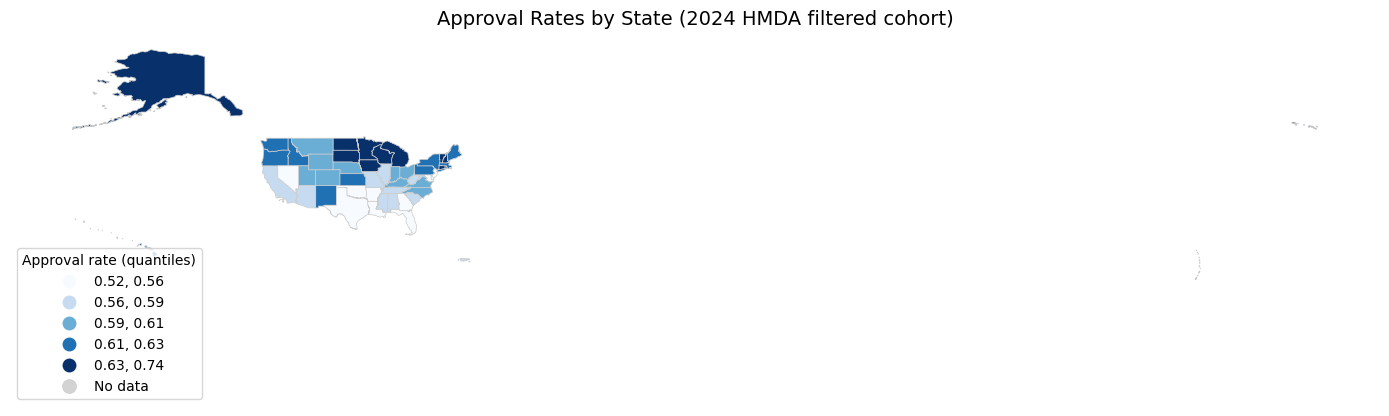

Saved: output/figures/choropleth_state_fixed_abbrev_2024.png


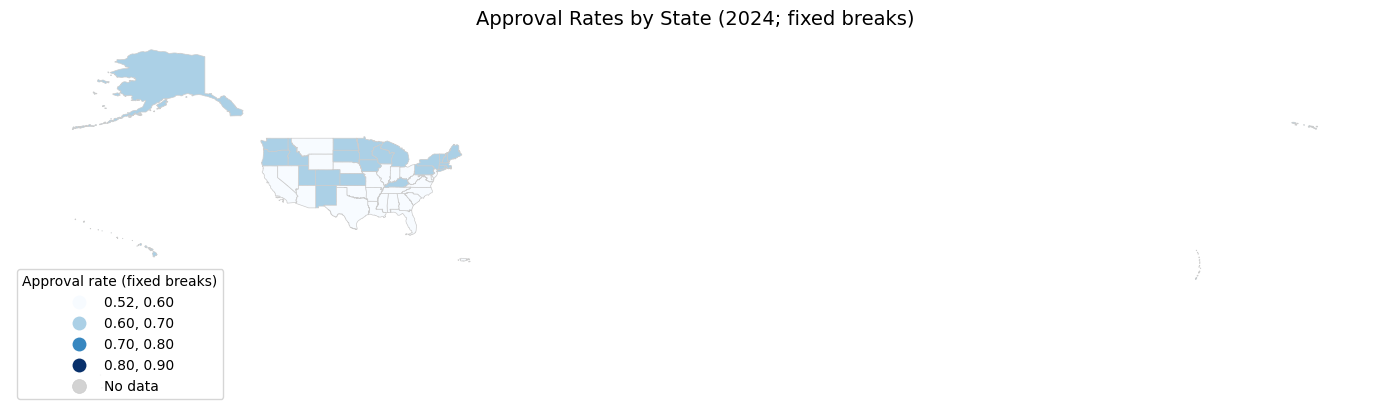

Saved: output/figures/choropleth_cbsa_quantiles_labels_2024.png


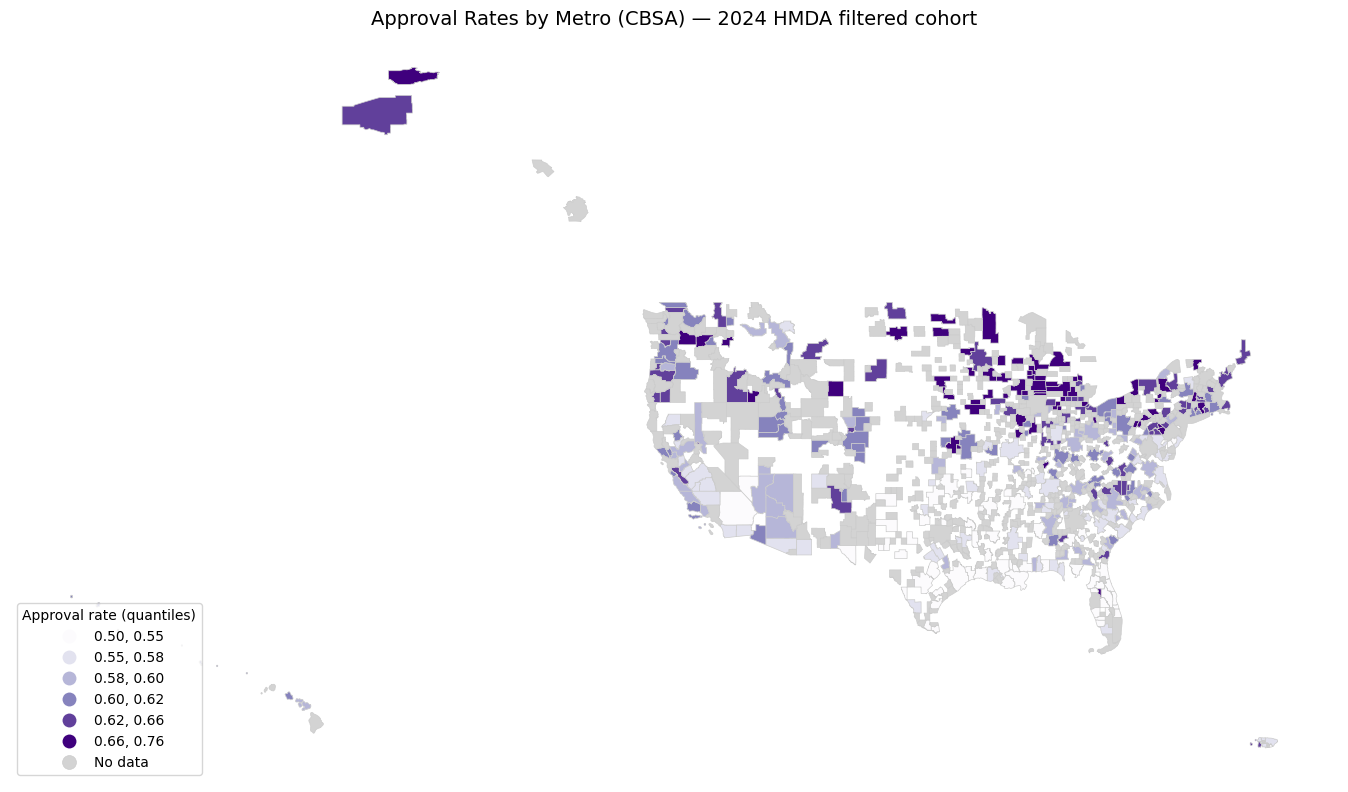

Saved: output/figures/choropleth_cbsa_fixed_labels_2024.png


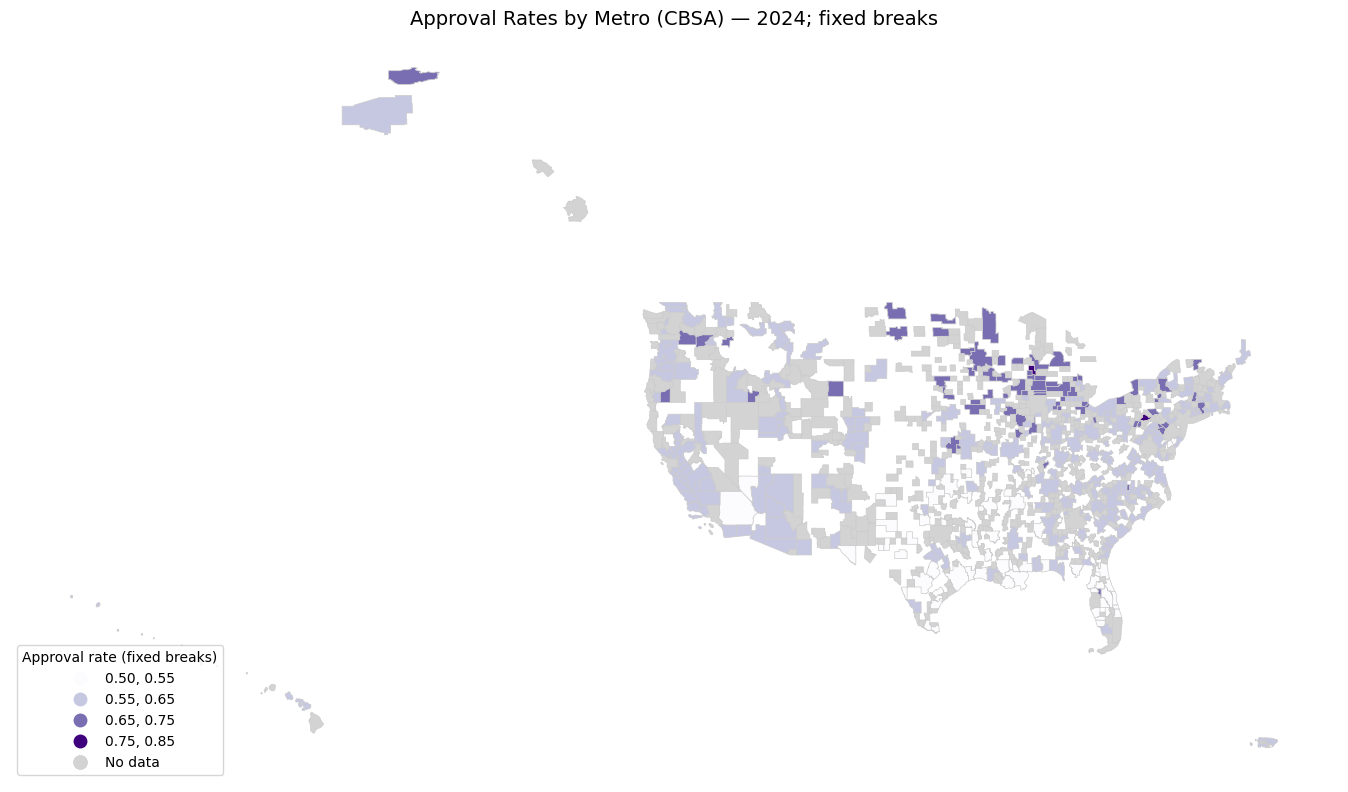

In [ ]:

# 13) Render maps
# State — Quantiles + abbreviations
plot_choropleth_with_labels(
    gdf=gdf_state_merged, value_col='approval_rate',
    title='Approval Rates by State (2024 HMDA filtered cohort)',
    outfile=f'{OUT_FIG_DIR}/choropleth_state_quantiles_abbrev_2024.png',
    scheme='Quantiles', k=5, cmap='Blues',
    legend_title='Approval rate (quantiles)',
    #label_col='state_code', label_top_n=50, label_fontsize=9
)

# State — Fixed breaks + abbreviations
fixed_bins_state = [0.60, 0.70, 0.80, 0.90]  # tune to distribution
plot_choropleth_with_labels(
    gdf=gdf_state_merged, value_col='approval_rate',
    title='Approval Rates by State (2024; fixed breaks)',
    outfile=f'{OUT_FIG_DIR}/choropleth_state_fixed_abbrev_2024.png',
    scheme='UserDefined', bins=fixed_bins_state, cmap='Blues',
    legend_title='Approval rate (fixed breaks)',
    #label_col='state_code', label_top_n=50, label_fontsize=9
)

# CBSA — Quantiles + limited labels
plot_choropleth_with_labels(
    gdf=gdf_cbsa_merged, value_col='approval_rate',
    title='Approval Rates by Metro (CBSA) — 2024 HMDA filtered cohort',
    outfile=f'{OUT_FIG_DIR}/choropleth_cbsa_quantiles_labels_2024.png',
    scheme='Quantiles', k=6, cmap='Purples',
    legend_title='Approval rate (quantiles)',
    #label_col='NAME', label_top_n=30, label_fontsize=7.5
)

# CBSA — Fixed breaks + limited labels
fixed_bins_cbsa = [0.55, 0.65, 0.75, 0.85]  # tune to distribution
plot_choropleth_with_labels(
    gdf=gdf_cbsa_merged, value_col='approval_rate',
    title='Approval Rates by Metro (CBSA) — 2024; fixed breaks',
    outfile=f'{OUT_FIG_DIR}/choropleth_cbsa_fixed_labels_2024.png',
    scheme='UserDefined', bins=fixed_bins_cbsa, cmap='Purples',
    legend_title='Approval rate (fixed breaks)',
    #label_col='NAME', label_top_n=30, label_fontsize=7.5
)


### 14) Bar Charts with 95% Confidence Intervals for Top/Bottom States


**Top 10 States:**
This chart highlights the approval rates for the top 10 states (those meeting our minimum application threshold and excluding territories). Includes their 95% Wilson confidence intervals.

**Bottom 10 States:**
Similarly, this chart shows the approval rates for the bottom 10 states (again, meeting our inclusion criteria), and their 95% Wilson confidence intervals.

These charts make it super easy to visually grasp the variation in state-level approval rates and understand how reliable our estimates are. Both figures will be saved as handy PNG images.

Note to self: Any improvement would be to plot these on the same figure come back and revise.

Saved: output/figures/bar_top10_approval_rate_ci.png


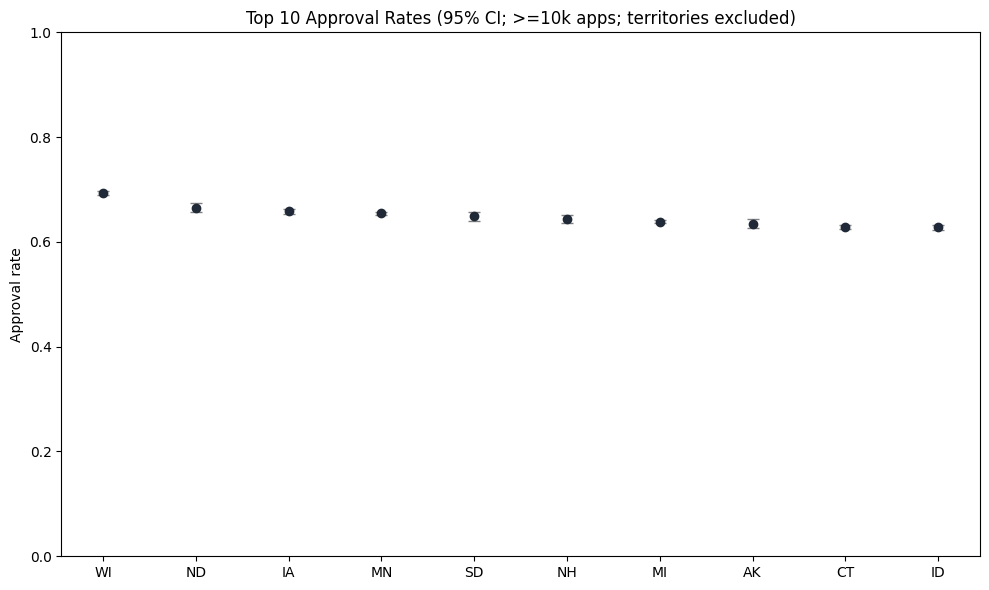

Saved: output/figures/bar_bottom10_approval_rate_ci.png


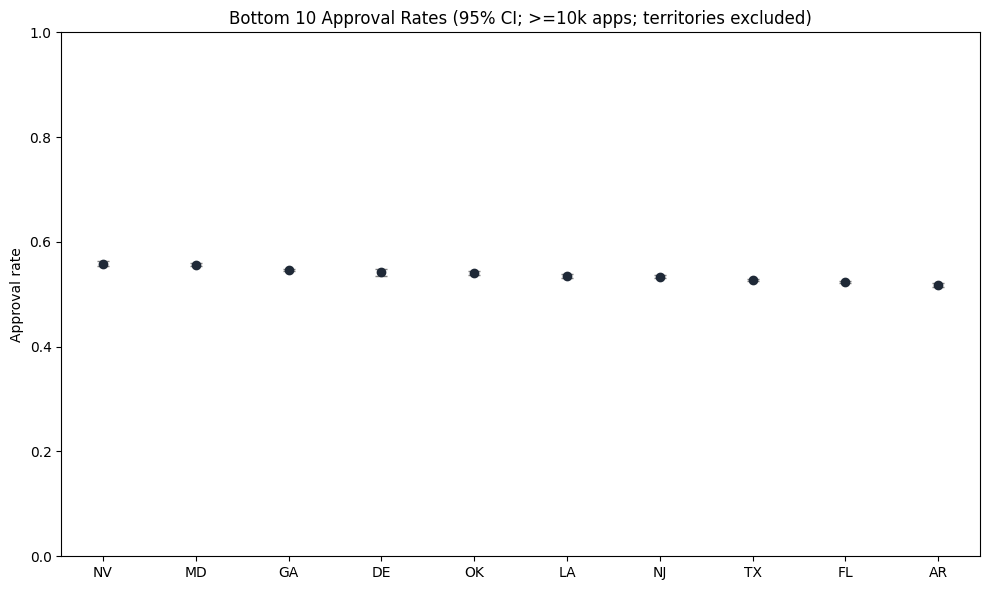

In [ ]:

# 14) Bar charts with 95% CIs for top/bottom states
import numpy as np
import matplotlib.pyplot as plt

top10 = robust_rank.head(10)
plt.figure(figsize=(10,6))
plt.errorbar(
    x=np.arange(len(top10)),
    y=top10['approval_rate'],
    yerr=[top10['approval_rate'] - top10['ci_low'], top10['ci_high'] - top10['approval_rate']],
    fmt='o', ecolor='gray', capsize=4, color='#1f2937'
)
plt.xticks(np.arange(len(top10)), top10['state_code'], rotation=0)
plt.ylim(0, 1)
plt.ylabel('Approval rate')
plt.title('Top 10 Approval Rates (95% CI; >=10k apps; territories excluded)')
plt.tight_layout()
safe_save_fig(f'{OUT_FIG_DIR}/bar_top10_approval_rate_ci.png', dpi=300)
plt.show()

bottom10 = robust_rank.tail(10)
plt.figure(figsize=(10,6))
plt.errorbar(
    x=np.arange(len(bottom10)),
    y=bottom10['approval_rate'],
    yerr=[bottom10['approval_rate'] - bottom10['ci_low'], bottom10['ci_high'] - bottom10['approval_rate']],
    fmt='o', ecolor='gray', capsize=4, color='#1f2937'
)
plt.xticks(np.arange(len(bottom10)), bottom10['state_code'], rotation=0)
plt.ylim(0, 1)
plt.ylabel('Approval rate')
plt.title('Bottom 10 Approval Rates (95% CI; >=10k apps; territories excluded)')
plt.tight_layout()
safe_save_fig(f'{OUT_FIG_DIR}/bar_bottom10_approval_rate_ci.png', dpi=300)
plt.show()


### 15) Sanity Check

Time for a quick check-up! This section performs a 'sanity check' on the data and the environment. Print out the versions of all the key Python libraries we're using (like `NumPy`, `pandas`, `GeoPandas`, `Shapely`, and `mapclassify`).

Quick summary statistics on our filtered HMDA cohort, including the total number of rows, applications, and approvals, plus the overall approval rate. Display the counts of approved applications that have valid rate spread data, broken down by applicant gender.

Just a little peek behind the curtain to ensure everything's looking good!

In [ ]:

# 15) Sanity Check
import numpy as np, pandas as pd
try:
    import geopandas as gpd, shapely, mapclassify
    print("NumPy:", np.__version__, "| pandas:", pd.__version__,
          "| GeoPandas:", gpd.__version__, "| Shapely:", shapely.__version__,
          "| mapclassify:", mapclassify.__version__)
except Exception as e:
    print("Version check:", e)

# Cohort sanity
total_rows = len(df_f)
apps = len(df_f)
approvals = int(df_f['approved'].sum())
print(f"Cohort rows: {total_rows} | Applications: {apps} | Approvals: {approvals} "
      f"({approvals/apps:.1%})")

# Approved + valid rate_spread + sex
mask = (df_f['approved']==1) & (df_f['rate_spread'].notna())
counts = df_f.loc[mask, 'derived_sex'].value_counts(dropna=False)
print("Approved & rate_spread available by sex:\n", counts)


NumPy: 2.0.2 | pandas: 2.2.2 | GeoPandas: 1.1.1 | Shapely: 2.1.2 | mapclassify: 2.10.0
Cohort rows: 5294989 | Applications: 5294989 | Approvals: 2964537 (56.0%)
Approved & rate_spread available by sex:
 derived_sex
Joint                1136802
Male                  949143
Female                620783
Sex Not Available     140553
Name: count, dtype: int64


### 16) Print Results for Top/Bottom States

This cell simply re-displays the top and bottom 10 states by approval rate. Calculated in Section 5, but it's handy to see them again here for a quick overview of which states are leading and lagging in approval rates, after filtering out territories and those with too few applications.

In [ ]:
# 16) print results
print("Top 10 states (>=10k apps, territories excluded):")
display(robust_rank.head(10))
print("Bottom 10 states (>=10k apps, territories excluded):")
display(robust_rank.tail(10))


Top 10 states (>=10k apps, territories excluded):


state_code    apps  approvals  approval_rate    ci_low   ci_high
0         WI   77569      53809       0.693692  0.690439  0.696926
1         ND   10836       7213       0.665652  0.656712  0.674474
2         IA   51131      33659       0.658289  0.654167  0.662388
3         MN   93093      60955       0.654775  0.651715  0.657823
4         SD   12488       8099       0.648543  0.640125  0.656869
5         NH   18349      11808       0.643523  0.636563  0.650422
6         MI  136838      87409       0.638777  0.636228  0.641318
7         AK   10318       6552       0.635007  0.625669  0.644244
8         CT   50030      31419       0.628003  0.623758  0.632229
9         ID   35500      22278       0.627549  0.622507  0.632564

Bottom 10 states (>=10k apps, territories excluded):


state_code    apps  approvals  approval_rate    ci_low   ci_high
38         NV   59781      33400       0.558706  0.554722  0.562682
39         MD  104374      58067       0.556336  0.553320  0.559348
40         GA  200043     109379       0.546777  0.544595  0.548958
41         DE   19996      10832       0.541708  0.534795  0.548606
42         OK   65631      35488       0.540720  0.536905  0.544530
43         LA   58499      31324       0.535462  0.531418  0.539501
44         NJ  125883      67189       0.533742  0.530985  0.536496
45         TX  576747     303996       0.527087  0.525799  0.528376
46         FL  462751     242180       0.523348  0.521909  0.524787
47         AR   52671      27280       0.517932  0.513664  0.522198

### 17) Rate Spread Analysis by Sex (Pre-Winsorization)

How available and distributed is the `rate_spread` information for approved loans when broken down by applicant sex. First, calculate the frequency of `rate_spread` data and count of records available for `female`, `male`, `joint`, and `sex not available` applications.

Then, look at the percentiles (specifically the 1st, 25th, 50th, 75th, and 99th) of the `rate_spread` for `female` and `male` applicants. Helps to understand the spread of the data, especially the extreme ends, before applying any winsorization. Raw view of the distribution tails.

In [ ]:
# 17) Rate Spread by sex
# Availability of rate_spread among approvals by sex
mask = (df_f['approved']==1)
avail = (
    df_f.loc[mask]
        .assign(has_rs = df_f.loc[mask,'rate_spread'].notna())
        .groupby('derived_sex')['has_rs']
        .agg(['sum','count'])
        .assign(availability=lambda d: d['sum']/d['count'])
)
display(avail)

# Tails by sex (pre-winsorization)
for s in ['Female','Male']:
    series = df_f.loc[mask & (df_f['derived_sex']==s),'rate_spread'].dropna()
    q = series.quantile([0.01,0.25,0.50,0.75,0.99])
    print(f"\n{ s } rate_spread quantiles:\n{ q }")


sum    count  availability
derived_sex                                      
Female              620783   646059      0.960877
Joint              1136802  1186679      0.957969
Male                949143   985250      0.963352
Sex Not Available   140553   146549      0.959085


Female rate_spread quantiles:
0.01   -6.66000
0.25   -0.21500
0.50    0.19800
0.75    0.63400
0.99    2.61818
Name: rate_spread, dtype: float64

Male rate_spread quantiles:
0.01   -6.430
0.25   -0.257
0.50    0.165
0.75    0.607
0.99    2.760
Name: rate_spread, dtype: float64


### 18) Suggest Fixed Breaks for Choropleth Map

This cell sets 'fixed breaks' for the choropleth maps, which are calculated based on the percentiles of the approval rates from our state ranking. Calculate the 10th, 30th, 50th, 70th, and 90th percentiles of the `approval_rate` for states that have enough data.

In [ ]:

# 18) Suggest fixed breaks from percentiles of the robust set
import numpy as np

vals = robust_rank['approval_rate'].dropna().values
p = np.percentile(vals, [10, 30, 50, 70, 90])  # edit percentiles to taste
bins_suggested = [float(x) for x in p]
print("Suggested bins (UserDefined):", bins_suggested)


Suggested bins (UserDefined): [0.5391427039767415, 0.5737179435540092, 0.597961305254707, 0.6132814234560227, 0.6450287457167666]


### 19) Choropleth Map of State Approval Rates with Tuned Fixed Breaks

This section creates a choropleth map that visualizes state-level approval rates using the custom set of fixed breaks. This is different from a quantile-based map because it manually tweaks the boundaries of the classes to highlight specific ranges of approval rates.

To update these fixed breaks return to Step 18 and update the breaks that are hard coded in this statement:

`p = np.percentile(vals, [10, 30, 50, 70, 90])`

Originally, the mapping included state abbreviations as labels but it made the visual way to busy so they are commented out currently.

Remove the `#` from these two lines before run to show labels

`#label_col='state_code', label_top_n=50, label_fontsize=9,`
`#use_halo=True, halo_color='white', halo_width=2`

Then save the final image to output directory.

Saved: output/figures/choropleth_state_fixed_abbrev_2024.png


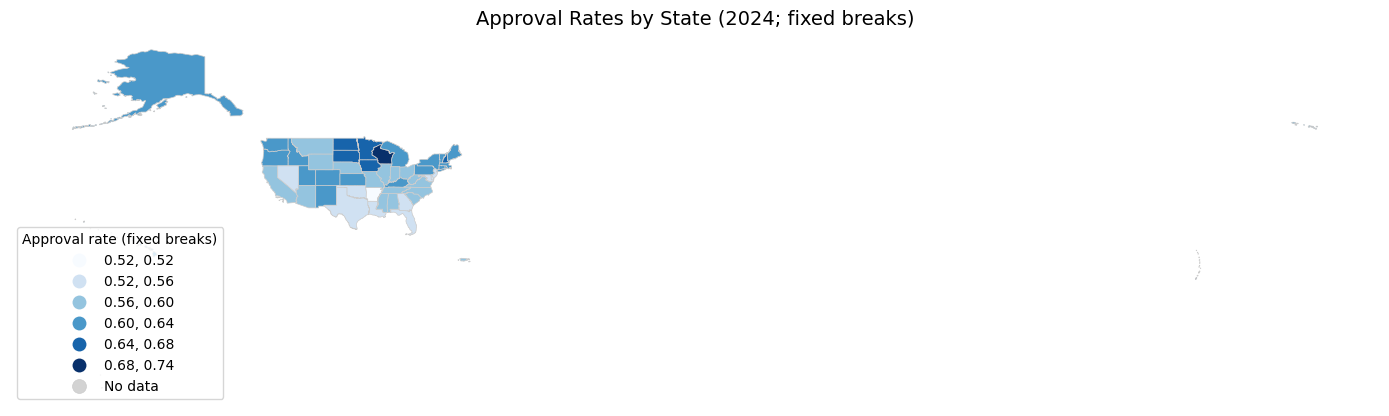

In [ ]:

# 19) Fixed breaks tuned to your distribution (five classes)
fixed_bins_state = [0.52, 0.56, 0.60, 0.64, 0.68]

plot_choropleth_with_labels(
    gdf=gdf_state_merged, value_col='approval_rate',
    title='Approval Rates by State (2024; fixed breaks)',
    outfile=f'{OUT_FIG_DIR}/choropleth_state_fixed_abbrev_2024.png',
    scheme='UserDefined', bins=fixed_bins_state, cmap='Blues',
    legend_title='Approval rate (fixed breaks)',
   # label_col='state_code', label_top_n=50, label_fontsize=9,  # abbreviations
   # use_halo=True, halo_color='white', halo_width=2
)


### 20) Bar Chart: Top 10 State Approval Rates with Confidence Intervals

Generate an error bar chart that displays the approval rates for the top 10 states (pulled from `robust_rank` DataFrame) and include the 95% Wilson confidence intervals.

This chart gives a visual representation of which states have the highest approval rates and how precise those estimates are.



Saved: output/figures/bar_top10_approval_rate_ci.png


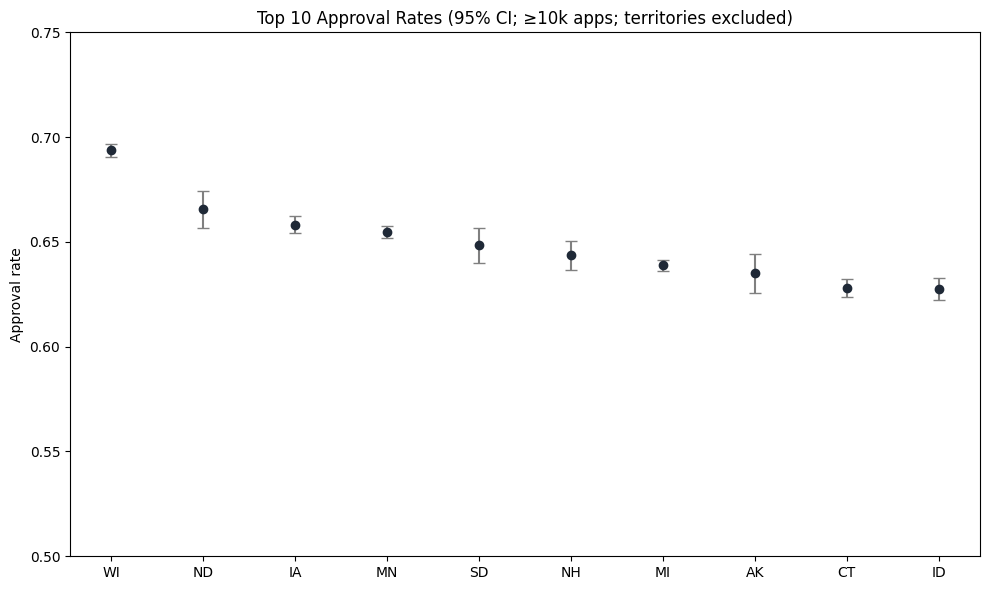

In [ ]:
# 20) top 10 approval
import numpy as np
import matplotlib.pyplot as plt

top10 = robust_rank.head(10)
plt.figure(figsize=(10,6))
plt.errorbar(
    x=np.arange(len(top10)), y=top10['approval_rate'],
    yerr=[top10['approval_rate'] - top10['ci_low'], top10['ci_high'] - top10['approval_rate']],
    fmt='o', ecolor='gray', capsize=4, color='#1f2937'
)
plt.xticks(np.arange(len(top10)), top10['state_code'], rotation=0)
plt.ylim(0.5, 0.75)
plt.ylabel('Approval rate')
plt.title('Top 10 Approval Rates (95% CI; ≥10k apps; territories excluded)')
plt.tight_layout()
safe_save_fig(f'{OUT_FIG_DIR}/bar_top10_approval_rate_ci.png', dpi=300)
plt.show()


### 21) Save Descriptive Statistics and Winsorized Rate Spread Pairs

This section stores data outputs to CSV file:

**rate_spread_descriptive_by_sex_approved_2024.csv**: This file contains all the descriptive statistics (like count, mean, standard deviation, minimum, quartiles, and maximum) for the winsorized rate spread data. Grouped by applicant sex for approved loans.

**rate_spread_winsorized_pairs_2024.csv**: This file holds the derived_sex and rate_spread columns specifically for approved and winsorized loans. This is the exact data we used in our t-test and OLS regression analysis, so it's perfect for anyone wanting to dive deeper or reproduce our results.

In [ ]:

# 22) Save descriptive stats & the winsorized pairs used for the t-test
safe_save_csv(desc, f'{OUT_TAB_DIR}/rate_spread_descriptive_by_sex_approved_2024.csv')
safe_save_csv(cond_ws[['derived_sex','rate_spread']], f'{OUT_TAB_DIR}/rate_spread_winsorized_pairs_2024.csv', index=False)


Saved: output/tables/rate_spread_descriptive_by_sex_approved_2024.csv
Saved: output/tables/rate_spread_winsorized_pairs_2024.csv


### 22) Save Unadjusted Female-Male Rate Spread Gap (Winsorized)

Package the unadjusted mean difference in winsorized rate spreads between female and male applicants for approved loans.

Create a `DataFrame` that includes everything: the female mean, the male mean, the gap expressed in basis points, the t-statistic, Welch's degrees of freedom, and the 95% confidence interval for that gap.

This `DataFrame` is then saved as **unadjusted_female_male_gap_winsorized_2024.csv**. Clear summary of the direct comparison of rate spreads by gender before any statistical adjustments are applied.

In [ ]:
# 22) Plug values computed should have written to variables inline maybe go back and revise later
import pandas as pd, math

# Plug in the values computed
gap_bps       = -1.419192674270714
se_pct_points = 0.001983596925647966
t_stat        = -7.154642437284064
df_welch      = 1235588.6738683356
ci_low_bps    = -1.8079776716977154
ci_high_bps   = -1.0304076768437125

unadj = pd.DataFrame([{
    'cohort': 'Approved + valid rate_spread (winsorized 1%/99%)',
    'female_mean': 0.07030325776479059,
    'male_mean':   0.08449518450749773,
    'gap_bps':     gap_bps,
    't_stat':      t_stat,
    'df_welch':    df_welch,
    'ci95_low_bps': ci_low_bps,
    'ci95_high_bps': ci_high_bps
}])

unadj.to_csv('output/tables/unadjusted_female_male_gap_winsorized_2024.csv', index=False)
print("Saved:", 'output/tables/unadjusted_female_male_gap_winsorized_2024.csv')


Saved: output/tables/unadjusted_female_male_gap_winsorized_2024.csv


### 23) Build CBSA-By-State Approval Tables

Random selection of state approval tables on a few key states (like Texas, Florida, Georgia, Virginia, and Vermont – easily tweak that list for different set of states!). For each of the named states, aggregate the approval rates by CBSA (metropolitan statistical area) and then sort them to see which metros are leading. Save these detailed, state-specific CBSA approval rate tables as CSV files, will allow exploration of the nuances in each state's metropolitan lending landscape.

In [ ]:

# 23) Build CBSA-by-state approval tables (e.g., for TX, FL, GA, VA)
states_focus = ['TX','FL','GA','VA', 'VT', 'WI', 'ND', 'NH', 'CT', 'SD', 'AR', 'LA']  # edit if you want others
rows = []
for st in states_focus:
    g = df_f[(df_f['state_code']==st) & (df_f['derived_msa_md'].notna())].copy()
    by_cbsa_st = (
        g.groupby('derived_msa_md')
         .agg(apps=('approved','size'), approvals=('approved','sum'))
         .assign(approval_rate=lambda d: d['approvals']/d['apps'])
         .reset_index()
         .sort_values('approval_rate', ascending=False)
    )
    by_cbsa_st.to_csv(f'output/tables/cbsa_approval_{st}_2024.csv', index=False)
    print("Saved:", f'output/tables/cbsa_approval_{st}_2024.csv')


Saved: output/tables/cbsa_approval_TX_2024.csv
Saved: output/tables/cbsa_approval_FL_2024.csv
Saved: output/tables/cbsa_approval_GA_2024.csv
Saved: output/tables/cbsa_approval_VA_2024.csv
Saved: output/tables/cbsa_approval_VT_2024.csv
Saved: output/tables/cbsa_approval_WI_2024.csv
Saved: output/tables/cbsa_approval_ND_2024.csv
Saved: output/tables/cbsa_approval_NH_2024.csv
Saved: output/tables/cbsa_approval_CT_2024.csv
Saved: output/tables/cbsa_approval_SD_2024.csv
Saved: output/tables/cbsa_approval_AR_2024.csv
Saved: output/tables/cbsa_approval_LA_2024.csv


### 24) Rate Spread Distribution by Gender (Winsorized)

This cell plots the distribution of the `Winsorized` rate spread data for approved loans, colored by applicant gender. Using a Kernel Density Estimate (KDE) plot, to see the shape and distributions for male and female applicants.

This visual does indicate a difference in loan packages.

*Note to self: Go back and create a distribution plot before normalizing as well, just because, maybe later.*

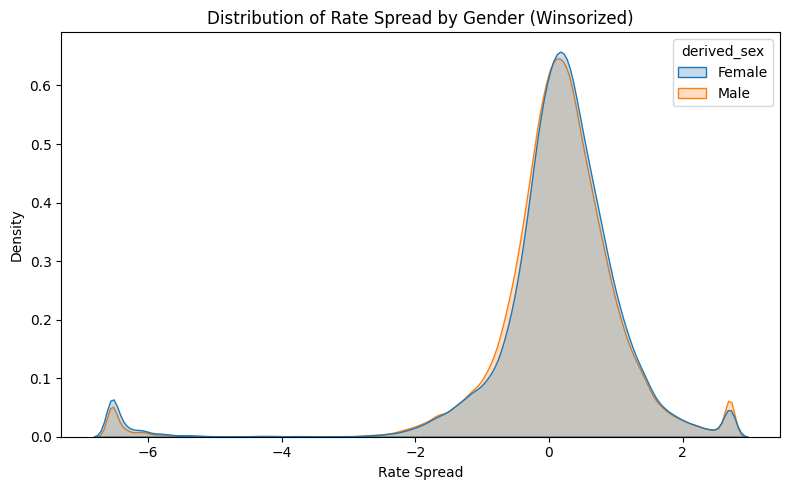

Saved: rate_spread_distribution_winsorized.png


In [ ]:
# 24) Rate Distro by derived_sex

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cond_ws DataFrame from your pipeline
plt.figure(figsize=(8,5))
sns.kdeplot(data=cond_ws, x="rate_spread", hue="derived_sex", fill=True, common_norm=False)
plt.title("Distribution of Rate Spread by Gender (Winsorized)")
plt.xlabel("Rate Spread")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig('output/figures/rate_spread_distribution_winsorized.png', dpi=300)
plt.show()
print("Saved: rate_spread_distribution_winsorized.png")


### 25) Approval Rate Heatmap by State and Loan Program

Generate a heatmap displaying the average loan approval rates across U.S. states and loan programs (Conventional, FHA, VA, USDA).

Provide a high-level visual overview of how approval rates vary geographically and by the type of loan product offered. The color intensity indicates the approval rate for each state-loan program combination.

It was the first attempt and I needed to spend sometime in the documentation. There is a lot of improvement left to do, but this is a start. https://matplotlib.org/stable/users/explain/quick_start.html#coding-styles

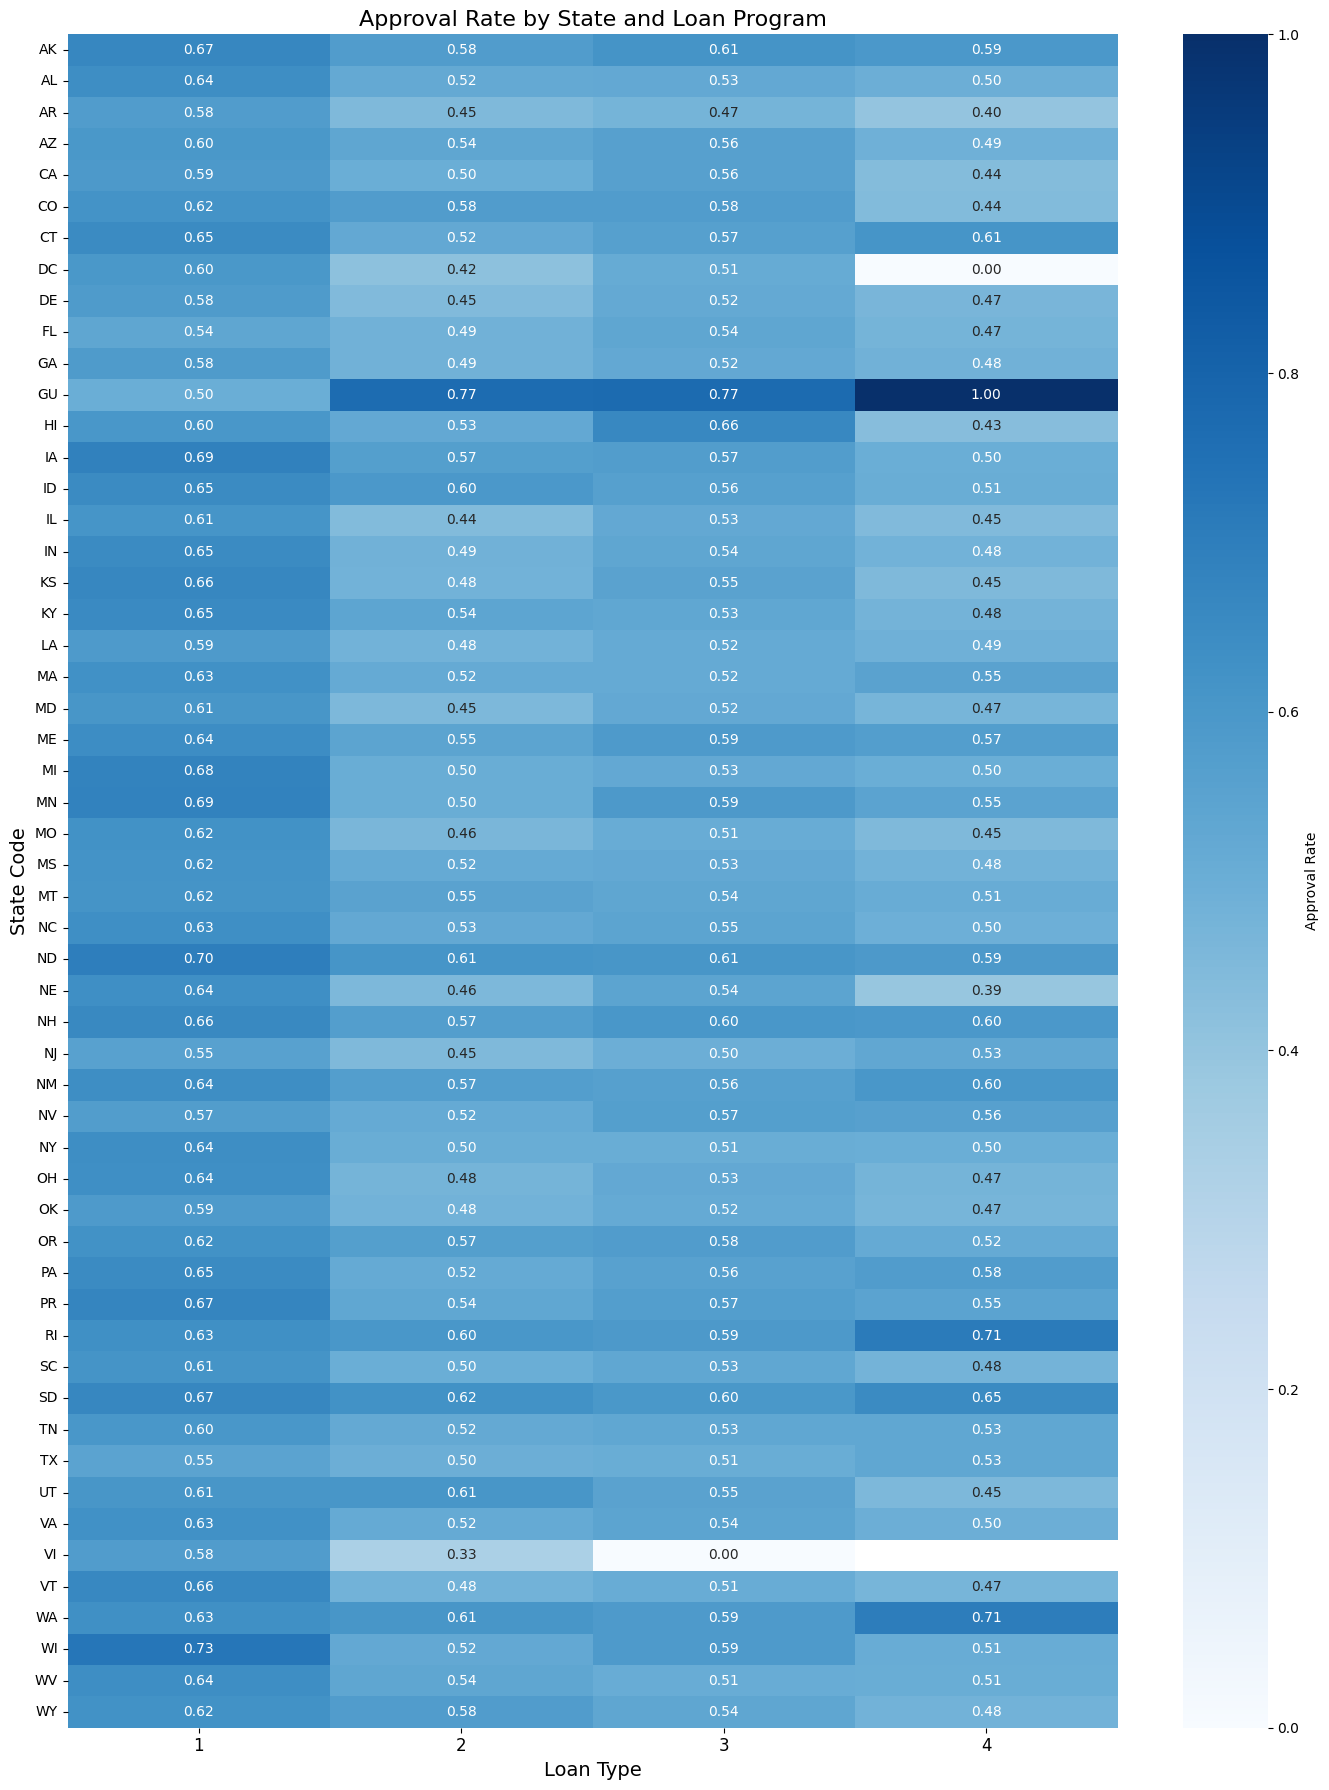

Saved: approval_rate_heatmap_state_program.png


In [ ]:
# 25 Approval Rate Heatmap by State and Loan Program
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot table for heatmap
pivot = df_f.groupby(['state_code','loan_type'])['approved'].mean().unstack()

# Plot heatmap with adjustments for labels
plt.figure(figsize=(14, 18))  # Increase height for all states
sns.heatmap(pivot, cmap="Blues", annot=True, fmt=".2f", cbar_kws={'label': 'Approval Rate'})

# Title and axis labels
plt.title("Approval Rate by State and Loan Program", fontsize=16)
plt.xlabel("Loan Type", fontsize=14)
plt.ylabel("State Code", fontsize=14)

# Ensure all state labels are visible
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=10)  # Keep states horizontal for readability

# Save to PNG
plt.tight_layout()
plt.savefig('output/figures/approval_rate_heatmap_state_program.png', dpi=300)

plt.show()
print("Saved: approval_rate_heatmap_state_program.png")


### 26) Diverging Approval Rate Heatmap by State and Loan Program

Building upon the previous heatmap, this cell provides a more refined visualization of approval rates by state and loan program. It maps numeric loan type codes to descriptive names and uses a diverging color scheme centered at 0.6. This allows for clearer identification of states and loan programs with approval rates significantly above or below this central threshold. Thin black lines are added to enhance visual separation between cells.

*Note to self: figure out how to get rid of the vertical lines, really want just the horizontal ones.*

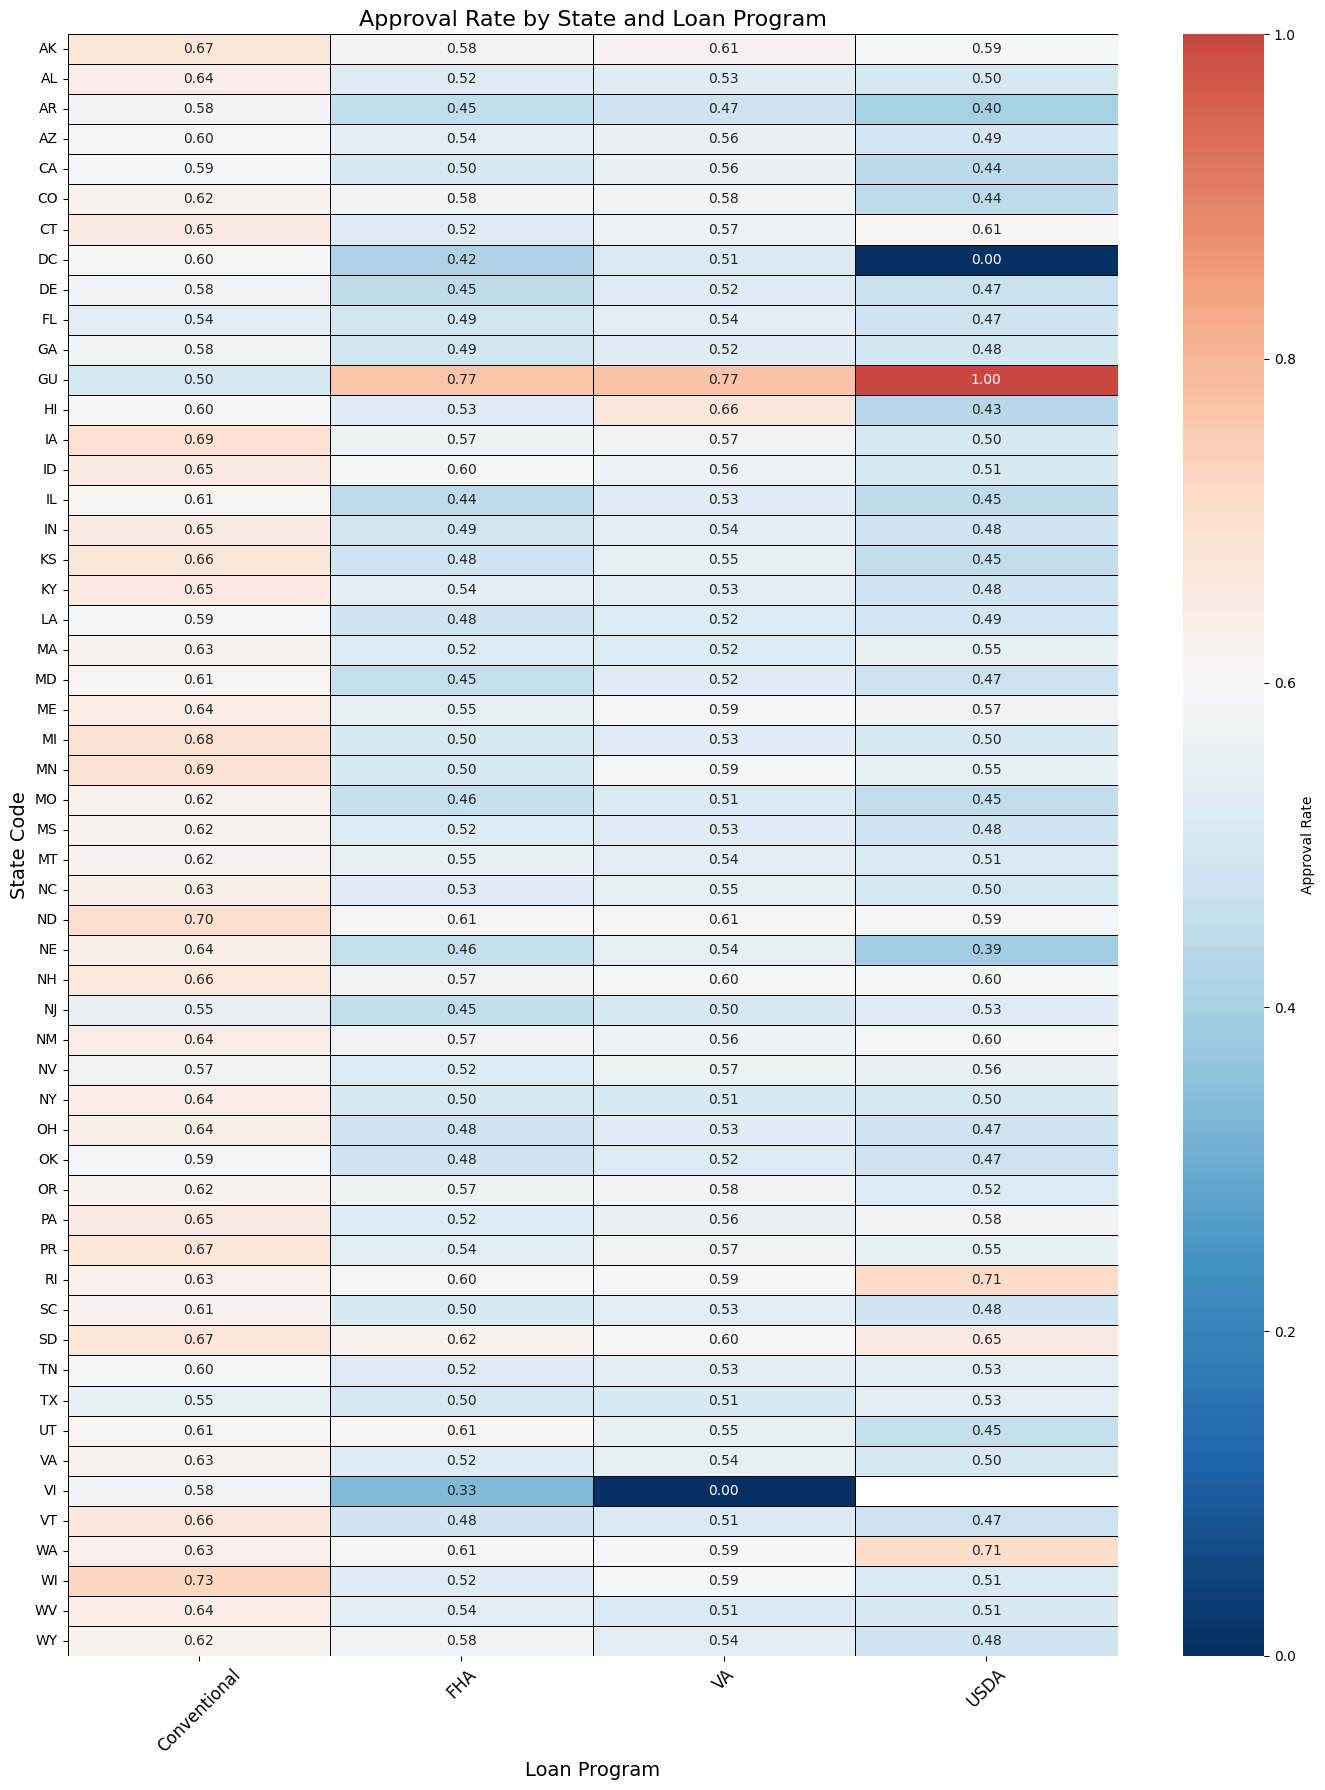

Saved: approval_rate_heatmap_state_program_diverging.png


In [ ]:
#26 Formatted with different color ramp: https://matplotlib.org/stable/users/explain/colors/colormaps.html
import seaborn as sns
import matplotlib.pyplot as plt

# Map loan type codes to names
loan_type_map = {1: 'Conventional', 2: 'FHA', 3: 'VA', 4: 'USDA'}

# Pivot table and rename columns
pivot = df_f.groupby(['state_code','loan_type'])['approved'].mean().unstack()
pivot.rename(columns=loan_type_map, inplace=True)

# Plot heatmap with diverging colors and boundaries
plt.figure(figsize=(14, 18))
sns.heatmap(
    pivot,
    cmap="RdBu_r",
    center=0.6,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Approval Rate'},
    linecolor='black',
    linewidths=0.5
)

plt.title("Approval Rate by State and Loan Program", fontsize=16)
plt.xlabel("Loan Program", fontsize=14)
plt.ylabel("State Code", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('output/figures/approval_rate_heatmap_state_program_diverging.png', dpi=300)
plt.show()
print("Saved: approval_rate_heatmap_state_program_diverging.png")


### 28) Approval Rate Heatmap by MSA and Loan Program

This cell generates a heatmap to visualize loan approval rates across Metropolitan Statistical Areas (MSAs) and different loan programs. To ensure readability, it first loads CBSA shapefile data to create a lookup table, mapping the numerical MSA IDs (`derived_msa_md`) to their corresponding geographical names. This allows the heatmap to display meaningful metro names on the y-axis, providing insights into metro-specific approval rate patterns.

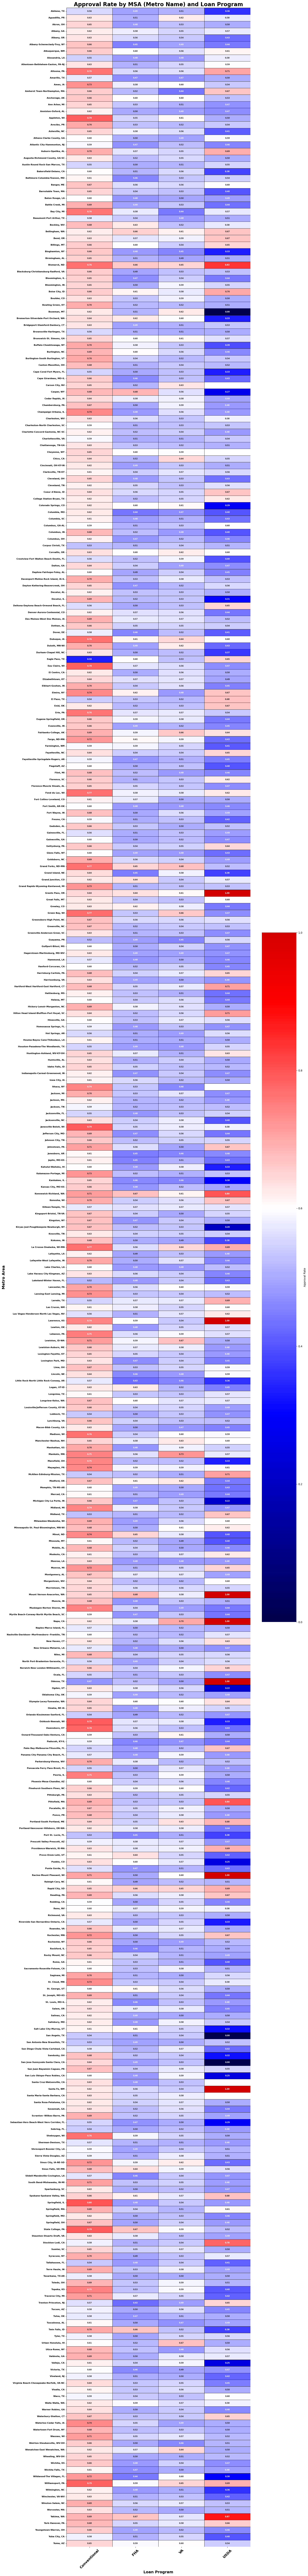

Saved: approval_rate_heatmap_msa_program_final.png


In [ ]:
# 28) Approval rate heatmap with properly formated columns

import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load CBSA shapefile for metro names
cbsa_shapefile = "/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2025_us_cbsa/tl_2025_us_cbsa.shp"
gdf_cbsa = gpd.read_file(cbsa_shapefile)

# 2. Create lookup table for CBSA ID → NAME
cbsa_lookup = gdf_cbsa[['CBSAFP', 'NAME']].rename(columns={'CBSAFP': 'derived_msa_md'})
cbsa_lookup['derived_msa_md'] = cbsa_lookup['derived_msa_md'].astype(str)

# 3. Pivot HMDA data by metro and loan type
pivot_msa = df_f.groupby(['derived_msa_md', 'loan_type'])['approved'].mean().unstack()
loan_type_map = {1: 'Conventional', 2: 'FHA', 3: 'VA', 4: 'USDA'}
pivot_msa.rename(columns=loan_type_map, inplace=True)

# Replace index IDs with metro names
pivot_msa.index = pivot_msa.index.map(cbsa_lookup.set_index('derived_msa_md')['NAME'])

# ✅ Drop rows where index is NaN (unmapped metro IDs)
pivot_msa = pivot_msa[~pivot_msa.index.isna()]


# 4. Plot optimized heatmap https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.figure(figsize=(16, len(pivot_msa)*0.35))  # Dynamic height
sns.heatmap(
    pivot_msa,
    cmap="seismic",          # Diverging color ramp
    center=0.6,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7, "weight": "bold"},
    cbar_kws={'label': 'Approval Rate'},
    linecolor='black',        # Horizontal grid lines only
    linewidths=0.5
)

# Remove vertical grid lines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Titles and labels
plt.title("Approval Rate by MSA (Metro Name) and Loan Program", fontsize=20, fontweight='bold')
plt.xlabel("Loan Program", fontsize=14, fontweight='bold')
plt.ylabel("Metro Area", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=13, fontweight='bold')
plt.yticks(rotation=0, fontsize=8, fontweight='bold')

# Save and show
plt.tight_layout()
plt.savefig('output/figures/approval_rate_heatmap_msa_program_final.png', dpi=400)
plt.show()
print("Saved: approval_rate_heatmap_msa_program_final.png")


### 29) Sorted Approval Rate Heatmap by MSA and Loan Program

This enhanced heatmap presents loan approval rates by MSA and loan program, with the MSAs sorted by their Conventional loan approval rates in descending order. This sorting strategy helps to quickly identify and compare MSAs that excel or underperform in Conventional loan approvals, and observe how this performance correlates across other loan programs. Dynamic sizing and optimized annotations are used for improved clarity.

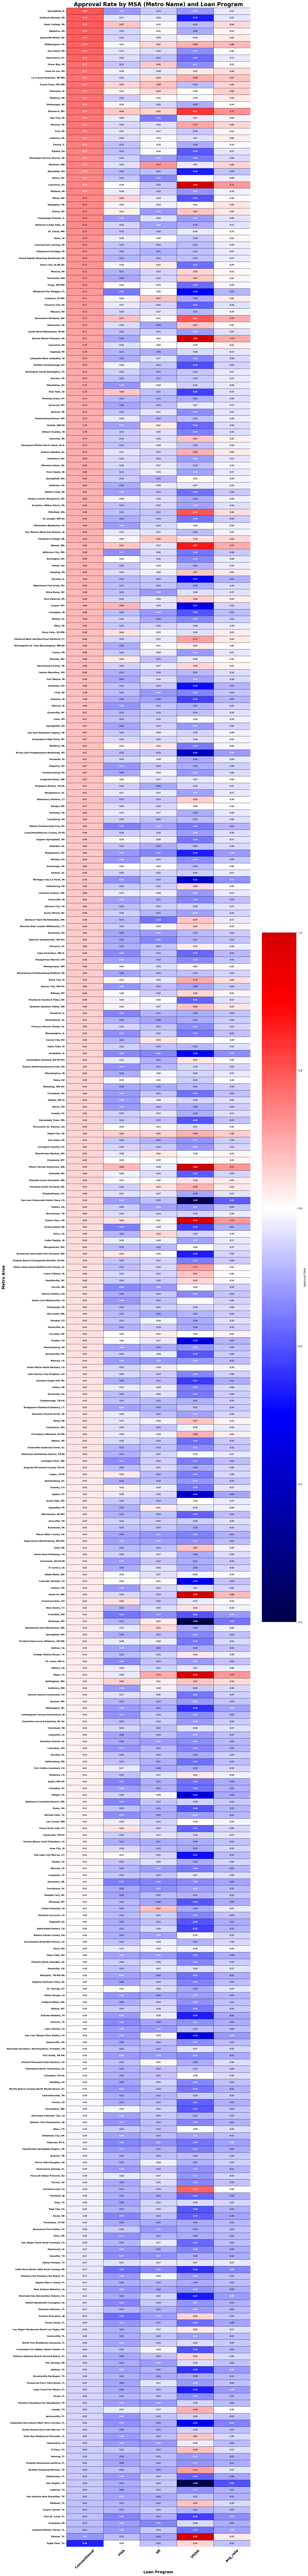

Saved: approval_rate_heatmap_msa_program_final.png


In [ ]:
# 29) Heatmap for MSA sorted by conventional loan approvals descending
import geopandas as gpd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load CBSA shapefile for metro names
cbsa_shapefile = "/content/drive/MyDrive/CIS-2330_Database_Fundamentals/tl_2025_us_cbsa/tl_2025_us_cbsa.shp"
gdf_cbsa = gpd.read_file(cbsa_shapefile)

# 2. Create lookup table for CBSA ID → NAME
cbsa_lookup = gdf_cbsa[['CBSAFP', 'NAME']].rename(columns={'CBSAFP': 'derived_msa_md'})
cbsa_lookup['derived_msa_md'] = cbsa_lookup['derived_msa_md'].astype(str)

# 3. Pivot HMDA data by metro and loan type
pivot_msa = df_f.groupby(['derived_msa_md', 'loan_type'])['approved'].mean().unstack()
loan_type_map = {1: 'Conventional', 2: 'FHA', 3: 'VA', 4: 'USDA'}
pivot_msa.rename(columns=loan_type_map, inplace=True)

# Replace index IDs with metro names
pivot_msa.index = pivot_msa.index.map(cbsa_lookup.set_index('derived_msa_md')['NAME'])

# ✅ Drop rows where index is NaN (unmapped metro IDs)
pivot_msa = pivot_msa[~pivot_msa.index.isna()]


# Sort by overall approval rate (mean across loan types)
pivot_msa['avg_rate'] = pivot_msa.mean(axis=1)

# Sort by Conventional loan approval rate
pivot_msa = pivot_msa.sort_values('Conventional', ascending=False)

# 4. Plot optimized heatmap https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.figure(figsize=(16, len(pivot_msa)*0.35))  # Dynamic height
sns.heatmap(
    pivot_msa,
    cmap="seismic",          # Diverging color ramp
    center=0.6,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 7, "weight": "bold"},
    cbar_kws={'label': 'Approval Rate'},
    linecolor='black',        # Horizontal grid lines only
    linewidths=0.5
)

# Remove vertical grid lines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Titles and labels
plt.title("Approval Rate by MSA (Metro Name) and Loan Program", fontsize=20, fontweight='bold')
plt.xlabel("Loan Program", fontsize=14, fontweight='bold')
plt.ylabel("Metro Area", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, fontsize=13, fontweight='bold')
plt.yticks(rotation=0, fontsize=8, fontweight='bold')

# Save and show
plt.tight_layout()
plt.savefig('output/figures/approval_rate_heatmap_msa_program_final.png', dpi=400)
plt.show()
print("Saved: approval_rate_heatmap_msa_program_final.png")


### 30) Sorted Approval Rate Heatmap by State and Loan Program

This cell visualizes loan approval rates across states and loan programs, with the states sorted by their Conventional loan approval rates in descending order. This sorting helps in identifying states that have higher (or lower) approval rates for Conventional loans and allows for a quick comparison of their performance across other loan programs (FHA, VA, USDA).

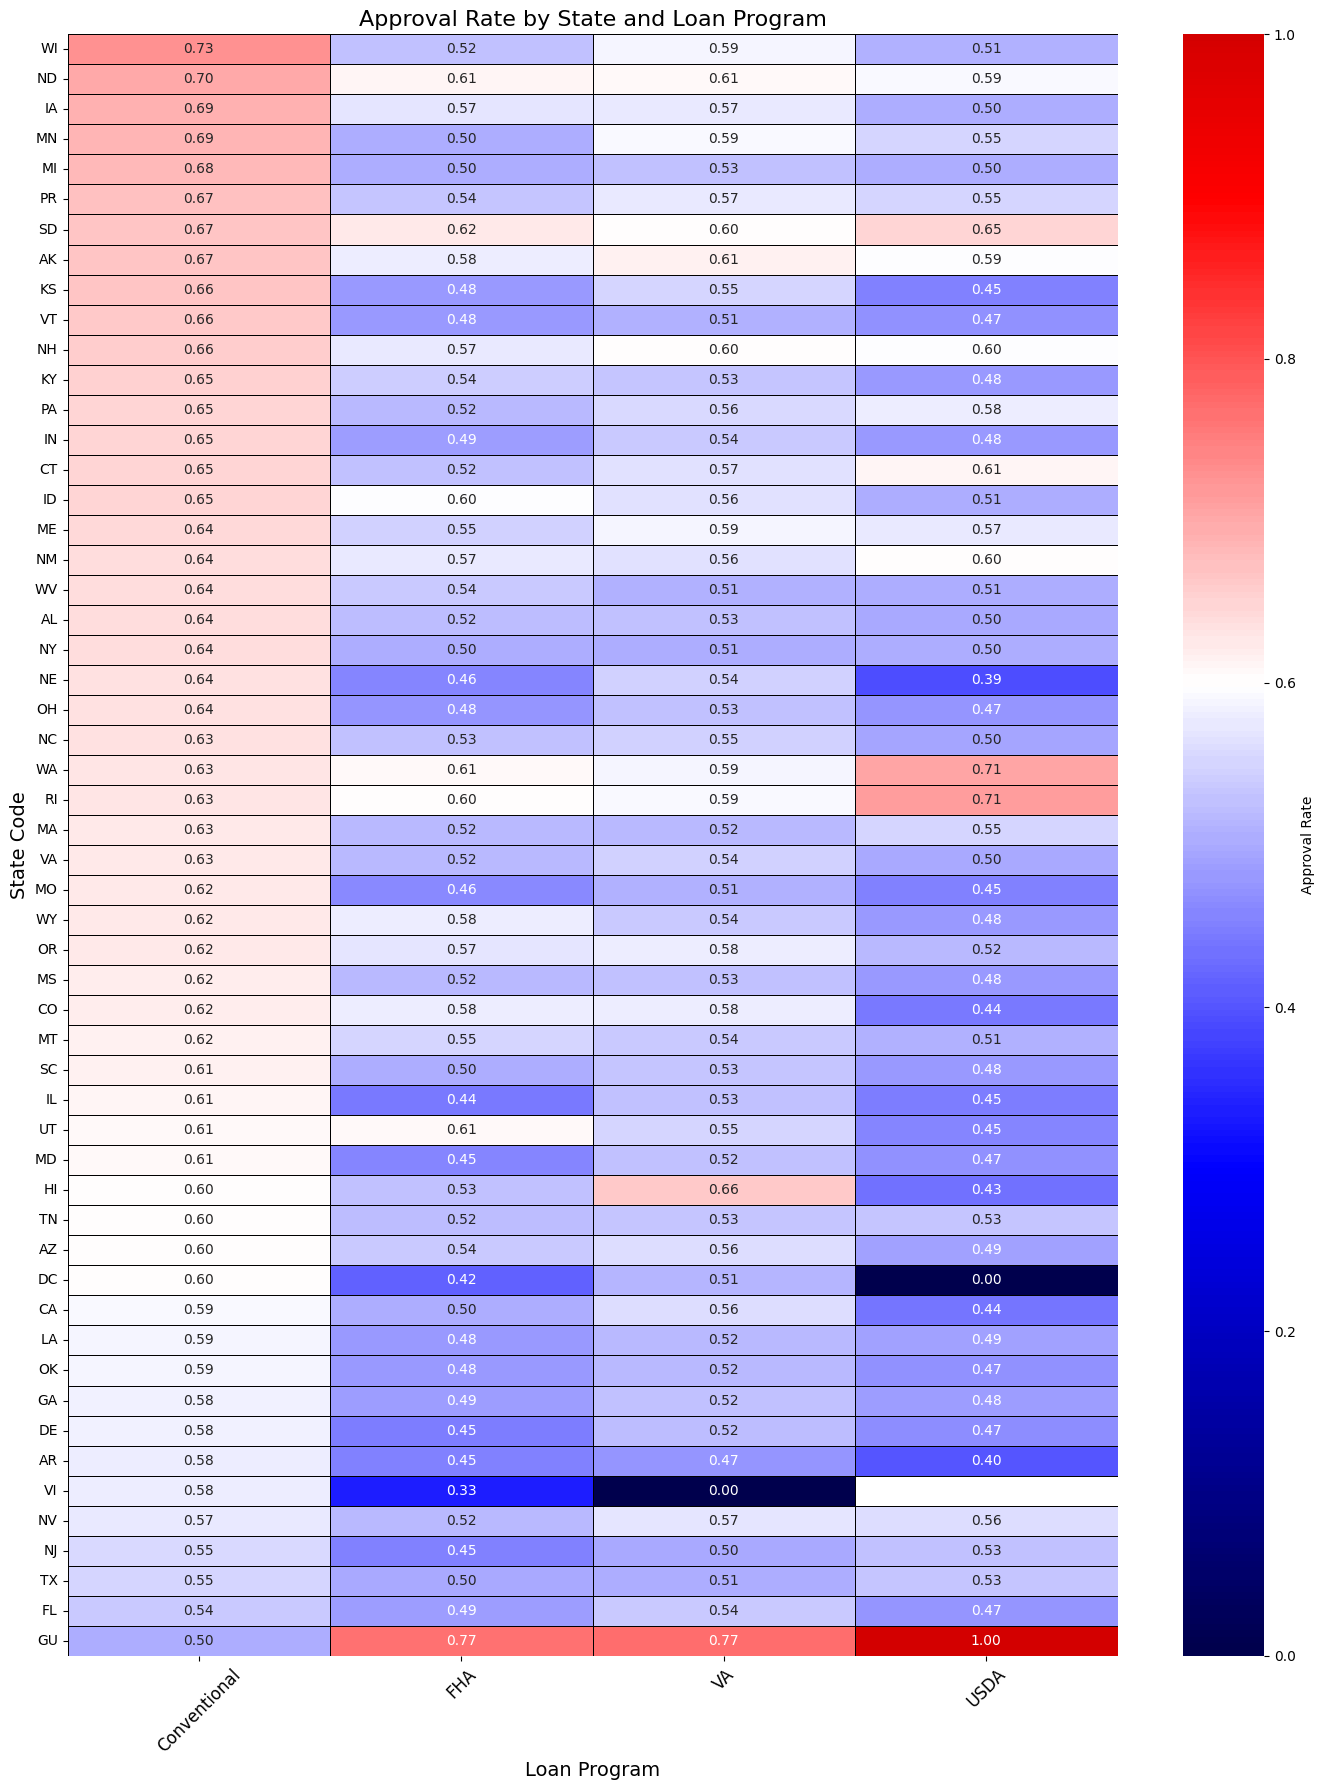

Saved: approval_rate_heatmap_state_program_diverging.png


In [ ]:
# 30) Re-Sort of State Heat map on Approval for conventional loans descending
import seaborn as sns
import matplotlib.pyplot as plt

# Map loan type codes to names
loan_type_map = {1: 'Conventional', 2: 'FHA', 3: 'VA', 4: 'USDA'}

# Pivot table and rename columns
pivot = df_f.groupby(['state_code','loan_type'])['approved'].mean().unstack()
pivot.rename(columns=loan_type_map, inplace=True)

pivot = pivot.sort_values('Conventional', ascending=False)

# Plot heatmap with diverging colors and boundaries
plt.figure(figsize=(14, 18))
sns.heatmap(
    pivot,
    cmap="seismic",
    center=0.6,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Approval Rate'},
    linecolor='black',
    linewidths=0.5
)

plt.title("Approval Rate by State and Loan Program", fontsize=16)
plt.xlabel("Loan Program", fontsize=14)
plt.ylabel("State Code", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.savefig('output/figures/approval_rate_heatmap_state_program_diverging.png', dpi=300)
plt.show()
print("Saved: approval_rate_heatmap_state_program_diverging.png")
